# Insurance for classification

## Problem description

Your task is to apply various ML algorithms (see the rules below) to build a model explaining travel insurance claim outcomes based on the training sample and generate predictions for all observations from the test sample.

The dataset includes travel insurance policy records with the following columns:

- reward – Commission value earned on the insurance sale

- claim_status – Target variable (0 = Not Approved, 1 = Approved) Only in training sample

- person_gender – Gender identifier of the insured person

- entity_type – Type of selling entity

- channel – Distribution channel used

- support_interactions – Number of customer service interactions

- agent_id – Identifier for the selling agent

- customer_score – Computed value between 0-1 based on customer metrics

- entity_a – Identifier of the agency that sold the policy

- person_age – Age of the insured person

- location – Destination of the trip

- revenue – Net sales value of the policy (when <0 it covers discounts)

- product_id – Name of the insurance product

- trip_length – Duration of the insured trip in days

## File description

- insurance_train.csv – training data contains 56993 observations and 14 columns along with the target variable claim_status

- insurance_test.csv – test data contains 6333 observations and 13 columns without the target variable

## Requirements

### Exploratory Data Analysis:
- Analyze the dataset to identify key patterns, correlations, and potential challenges introduced by the additional variables.
- Visualize distributions and relationships among variables.
### Feature Engineering:
- Consider transformation or scaling of variables as needed. 
- Evaluate the impact of the supplementary variables on model performance.
### Modeling:
- Build, train, and compare multiple regression models. 
- Optimize model hyperparameters using cross-validation.
### Predictions:
- Generate predictions for all observations in the test dataset. 
- Document model performance and reasoning behind the selected approach.
### Documentation:
- Provide a clear explanation of your analysis, modeling choices, and any challenges faced while integrating the additional variables.
## Various algorithms
For each of the datasets please consider and compare at least 3 different ML algorithms discussed in the ML1 course (e.g. linear/logistic regression, KNN, LASSO, ridge, elastic net, SVM/SVR with various kernel functions). You can also apply in addition any other algorithms you know, but they cannot be used instead of the ones mentioned before.

## Selection of the best algorithm
The choice of the final algorithm applied to generate predictions should be clearly explained in the presentation.

HINT !!!!! Use the internal division of the training data into train/validation/test samples to make sure that you correcly assess the performance of your models on the new data.

## Performance measure
The performance of predictions will be based on:

RMSE for the appartments dataset
balanced accuracy for the insurance dataset
Please report the expected value of a particular performance measure (expectation for the test sample) in your presentation.

#### Dependencies loading

In [1]:
# Standard library imports
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display, HTML

# Statsmodels imports
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Scikit-learn imports
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer, 
    OneHotEncoder, 
    PowerTransformer, 
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Category encoders
from category_encoders import TargetEncoder

# Imbalanced-learn imports
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pd.set_option("display.max_columns", 500)

np.random.seed(2115)

#### Path setup

Creating paths for project files
```python

In [2]:
raw_input_data_path = r"C:\Users\wojci\Desktop\Machine Learning\MachineLearning1\Insurances\data_input"
preprocessed_output_data_path = r"C:\Users\wojci\Desktop\Machine Learning\MachineLearning1\Insurances\data_output"

## Data preparation

#### Data loading

In [3]:
df = pd.read_csv(f"{raw_input_data_path}/insurance_train.csv")

In [4]:
df.sample(10)

,reward,claim_status,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
38941,3.490289,0,9b2d5b46,type_b,web,1,agt_0008,0.120951,b5e4bb23,48,singapore,12.400049,TripGuard TicketCover,66
25469,49.421638,0,9b2d5b46,type_a,web,1,agt_0001,0.275306,96d6c6df,44,italy,83.093531,DriveSafe Rental Addon,28
10106,54.310570,0,f67ab10a,type_b,web,2,agt_0005,0.369333,99ede4e4,42,singapore,223.247602,SecurePlan Annual Lite,374
51020,13.496401,0,f67ab10a,type_b,web,0,agt_0005,0.109287,99ede4e4,26,singapore,56.071373,TravelShield Plus,36
54192,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.226950,50b3e71e,38,israel,26.841574,SecurePlan Flex,32
3803,2.818914,0,f67ab10a,type_b,web,1,agt_0005,0.238494,99ede4e4,30,singapore,11.745844,TravelShield Core,6
1109,16.148170,0,08f27188,type_b,web,1,agt_0005,0.243082,99ede4e4,46,singapore,62.043173,TravelShield Plus,16
26755,0.000000,0,9b2d5b46,type_a,web,1,agt_0004,0.196204,50b3e71e,36,italy,46.905613,TripGuard Cancel,48
29232,0.000000,0,9b2d5b46,type_a,web,2,agt_0004,0.041296,50b3e71e,30,thailand,10.244600,TripGuard Cancel,33
22074,0.000000,0,9b2d5b46,type_a,web,2,agt_0004,0.141518,50b3e71e,35,spain,9.802957,TripGuard Cancel,99


On the first sight data look quite clean, we can see that gender and entity have been encoded so it's impossible to distinguish real values. Location is made by countries.

### Dataset adjustment

In [5]:
df.columns

Index(['reward', 'claim_status', 'person_gender', 'entity_type', 'channel',
       'support_interactions', 'agent_id', 'customer_score', 'entity_a',
       'person_age', 'location', 'revenue', 'product_id', 'trip_length'],
      dtype='object')

In [6]:
df.select_dtypes(include='object').nunique().to_frame()

,0
person_gender,3
entity_type,2
channel,2
agent_id,16
entity_a,16
location,146
product_id,26


We can see that loaction and product_id have a lot of unique values, maybe there will be a potential to group them.

#### Checking if every variable has proper type

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56993 entries, 0 to 56992
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reward                56993 non-null  float64
 1   claim_status          56993 non-null  int64  
 2   person_gender         56993 non-null  object 
 3   entity_type           56993 non-null  object 
 4   channel               56993 non-null  object 
 5   support_interactions  56993 non-null  int64  
 6   agent_id              56993 non-null  object 
 7   customer_score        56993 non-null  float64
 8   entity_a              56993 non-null  object 
 9   person_age            56993 non-null  int64  
 10  location              56993 non-null  object 
 11  revenue               56993 non-null  float64
 12  product_id            56993 non-null  object 
 13  trip_length           56993 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 6.1+ MB


#### Checking missing values percentage

In [8]:
missing_percent = (df.isna().sum() / len(df) * 100).round(2)
print(missing_percent)

reward                  0.0
claim_status            0.0
person_gender           0.0
entity_type             0.0
channel                 0.0
support_interactions    0.0
agent_id                0.0
customer_score          0.0
entity_a                0.0
person_age              0.0
location                0.0
revenue                 0.0
product_id              0.0
trip_length             0.0
dtype: float64


We don't have any columns with missing values.

In [9]:
print(df.describe())

             reward  claim_status  support_interactions  customer_score  \
count  56993.000000  56993.000000          56993.000000    56993.000000   
mean       9.794976      0.014633              1.093941        0.189540   
std       19.791119      0.120081              0.923113        0.080641   
min        0.000000      0.000000              0.000000        0.000000   
25%        0.000000      0.000000              0.000000        0.136389   
50%        0.000000      0.000000              1.000000        0.181041   
75%       11.336612      0.000000              2.000000        0.230836   
max      282.073580      1.000000              6.000000        1.000000   

         person_age       revenue   trip_length  
count  56993.000000  56993.000000  56993.000000  
mean      39.697261     40.750070     49.234888  
std       12.603433     48.749221     98.659469  
min       18.000000   -406.642669      1.000000  
25%       34.000000     18.246389      9.000000  
50%       36.000000     

We yet can see a potentially huge imbalance in the target variable, so we will need to take care of it. Also over half of reward values equal 0, so we will need to check if it is a problem or not.

#### Target variable distribution

Distribution of claim_status:
              Count  Percentage
claim_status                   
0             56159       98.54
1               834        1.46


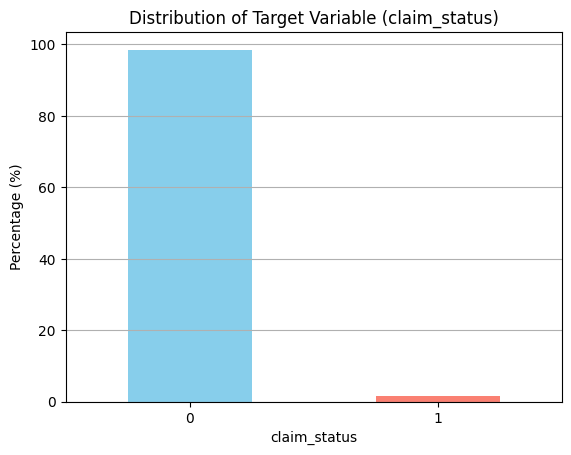

In [10]:
# Distribution of target variable (claim_status)
claim_counts = df['claim_status'].value_counts()
claim_percent = df['claim_status'].value_counts(normalize=True) * 100

# Table with distribution of claim_status
claim_distribution = pd.DataFrame({
    'Count': claim_counts,
    'Percentage': claim_percent.round(2)
})
print("Distribution of claim_status:")
print(claim_distribution)

# Plotting the distribution of target variable
claim_distribution['Percentage'].plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable (claim_status)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

We clearly see that we only have 1,46% of the data with claim_status = 1, so we have to deal with a very unbalanced dataset. We can use SMOTE to balance the dataset in the modeling phase.

#### Correlation Matrix

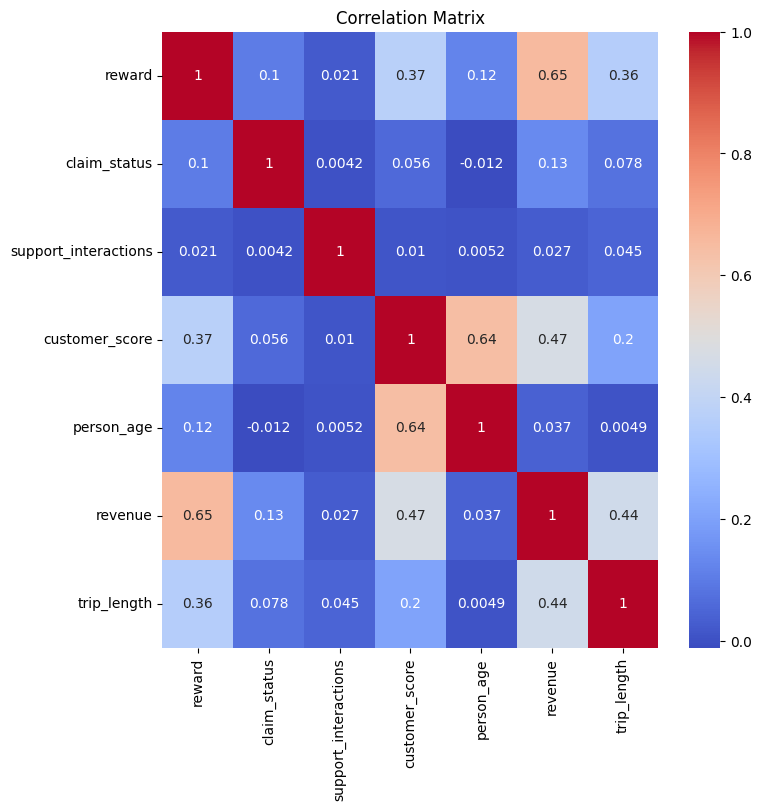

In [11]:
corr_columns = df.select_dtypes(include=[np.number])
plt.rcParams['font.size'] = 10
plt.figure(figsize=(8, 8))
sns.heatmap(corr_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Correlations with 'claim_status':

- reward (0.1): There is a weak positive correlation between 'reward' and 'claim_status'. This suggests that higher rewards are slightly associated with claims, which aligns with previous observations that claims often involve a reward.
- support_interactions (0.0042): Extremely weak, almost negligible positive correlation. This indicates that the number of 'support_interactions' has very little linear relationship with 'claim_status'.
- customer_score (0.056): Weak positive correlation. A slightly higher 'customer_score' is marginally associated with claims. This is counter-intuitive if higher scores mean better customers, so it might imply something about how "customer_score" is defined or its relationship with the claim process.
- person_age (-0.012): Very weak negative correlation. This indicates that 'person_age' has almost no linear relationship with 'claim_status'.
- revenue (0.13): A weak positive correlation. This suggests that higher 'revenue' is slightly associated with claims, which is consistent with the previous histogram analysis where claim-related revenue was generally higher.
- trip_length (0.078): A weak positive correlation. Longer 'trip_length' is slightly associated with claims, which also aligns with prior histogram analysis where claimed trips tended to be longer.

Overall for 'claim_status': The correlations with 'claim_status' are generally very weak.

Other Notable Correlations:

- reward & revenue (0.65): Strong positive correlation. This is intuitive; higher revenue often corresponds to higher rewards.
- reward & customer_score (0.37): Moderate positive correlation. Higher customer scores are somewhat associated with higher rewards.
- reward & trip_length (0.36): Moderate positive correlation. Longer trips are somewhat associated with higher rewards.
- customer_score & person_age (0.64): Strong positive correlation. Older individuals tend to have higher customer scores. This is a significant relationship.
- customer_score & revenue (0.47): Moderate positive correlation. Higher customer scores are associated with higher revenue.
- revenue & trip_length (0.44): Moderate positive correlation. Higher revenue is associated with longer trips.
- person_age & revenue (0.037): Very weak positive correlation. Despite the strong correlation between 'person_age' and 'customer_score', and 'customer_score' and 'revenue', the direct correlation between 'person_age' and 'revenue' is surprisingly weak. This implies that 'customer_score' might be acting as a mediator in the relationship between age and revenue, or other factors are at play.
- trip_length & revenue (0.44): Moderate positive correlation. This makes sense as longer trips might naturally incur more revenue.

#### Continuos variables

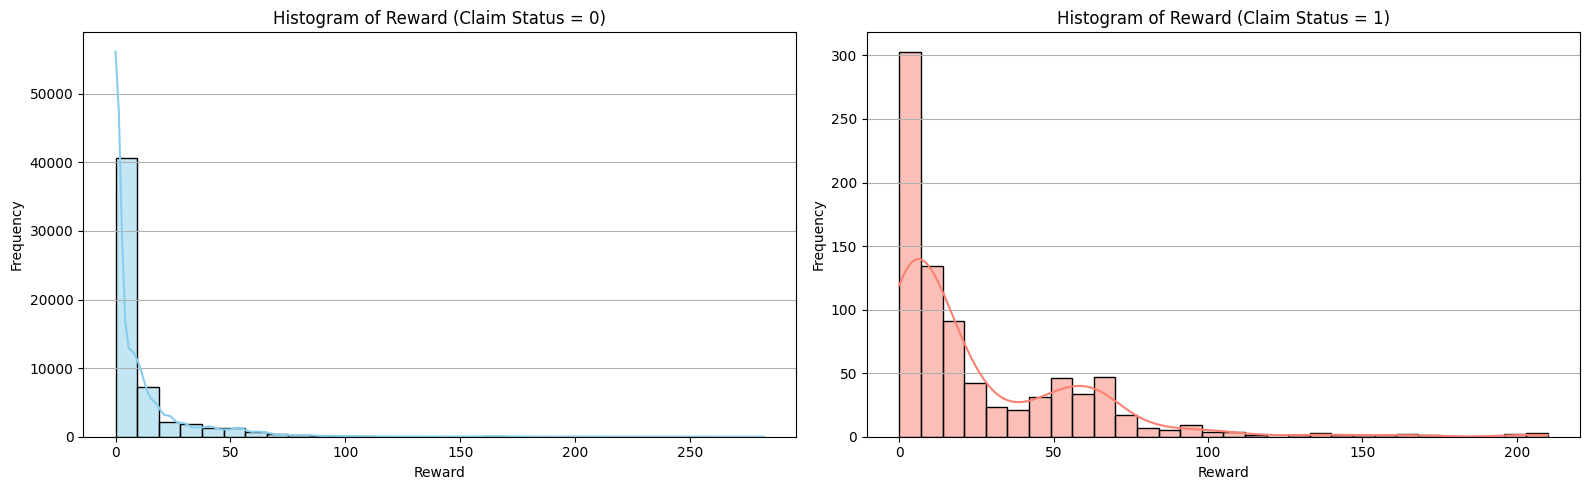

In [12]:
#Reward values on histogram - 2 separate plots by claim status
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # bez sharey=True

# Histogram for claim_status = 0
sns.histplot(data=df[df['claim_status'] == 0], x='reward', bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Reward (Claim Status = 0)')
axes[0].set_xlabel('Reward')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

# Histogram for claim_status = 1
sns.histplot(data=df[df['claim_status'] == 1], x='reward', bins=30, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Histogram of Reward (Claim Status = 1)')
axes[1].set_xlabel('Reward')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

Histograms of Original Reward

- Histogram of Reward (Claim Status = 0) (Left - Blue): This distribution is extremely right-skewed, with a very high frequency concentrated at or near zero 'Reward' values. A substantial number of observations have a 'Reward' of 0.
There's a long tail extending to positive 'Reward' values, but the vast majority of non-claim instances have no or very little reward.
This suggests that when no claim is made, the reward is typically zero or very small.
- Histogram of Reward (Claim Status = 1) (Right - Red):
This distribution is also highly right-skewed, but it starts at positive 'Reward' values (no zero or negative rewards are apparent). There's a peak around 10-20 units, followed by a long tail extending to higher reward values.
Compared to 'Claim Status = 0', the 'Claim Status = 1' distribution for 'Reward' is shifted towards positive values, indicating that when a claim occurs, it is generally higher than for non-claim cases.

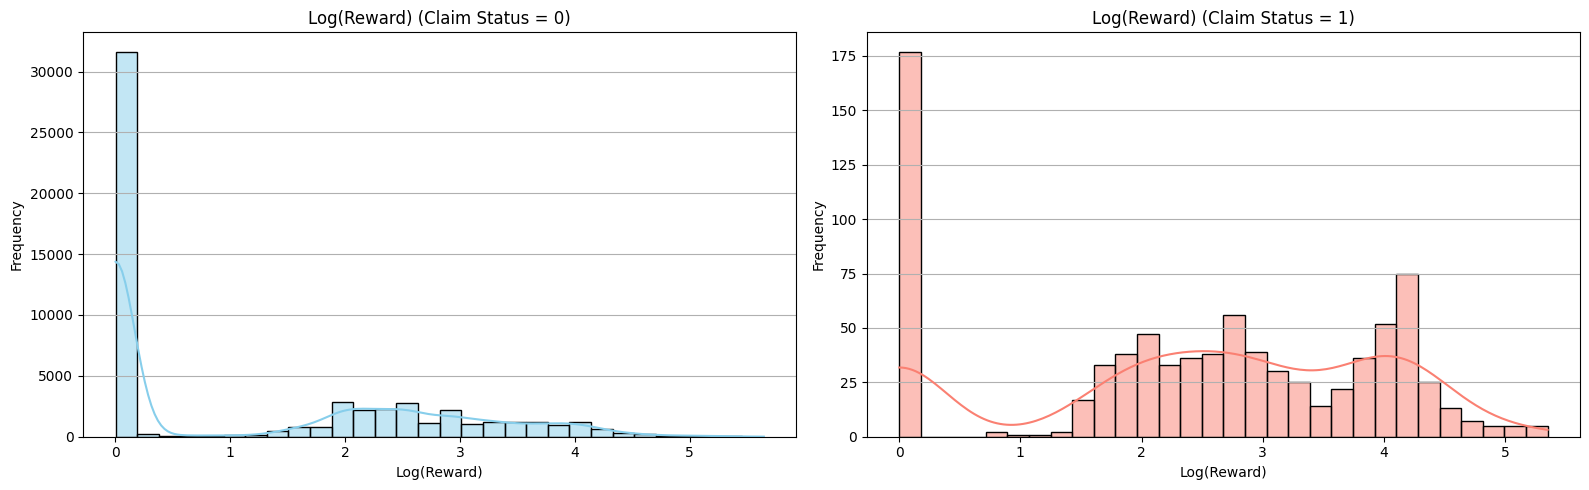

In [13]:
# Log-transformation of 'reward' column
df['log_reward'] = np.log((df['reward'] + 1).replace(0, 0.001)).replace(0, 0.001)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 wiersz, 2 kolumny

sns.histplot(data=df[df['claim_status'] == 0], x='log_reward', bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Log(Reward) (Claim Status = 0)')
axes[0].set_xlabel('Log(Reward)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

sns.histplot(data=df[df['claim_status'] == 1], x='log_reward', bins=30, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Log(Reward) (Claim Status = 1)')
axes[1].set_xlabel('Log(Reward)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


Histograms of Log-Transformed Reward (Log(Reward))

- Log(Reward) (Claim Status = 0) (Left - Blue):
The presence of zero 'Reward' values causes an issue for direct log transformation. The prominent spike at the far left of this histogram (likely representing the transformed zero or near-zero original 'Reward' values) indicates this.
For the non-zero 'Reward' values, the log transformation has reduced the skewness, but the distribution still appears heavily concentrated at lower log-transformed values, with a significant portion close to zero on the log scale.
- Log(Reward) (Claim Status = 1) (Right - Red):
The log transformation has made this distribution significantly more symmetrical and somewhat resembles a normal distribution, though it might still exhibit some multi-modality or be slightly skewed to the right. The extreme right skewness of the original 'Reward' for 'Claim Status = 1' has been largely mitigated.
The distribution spans from approximately 1.5 to 5 on the log scale, with peaks around 2.5-3.0 and another broader concentration around 4.0-5.0. However we of course can see that the prominent spike at the far left of this histogram.

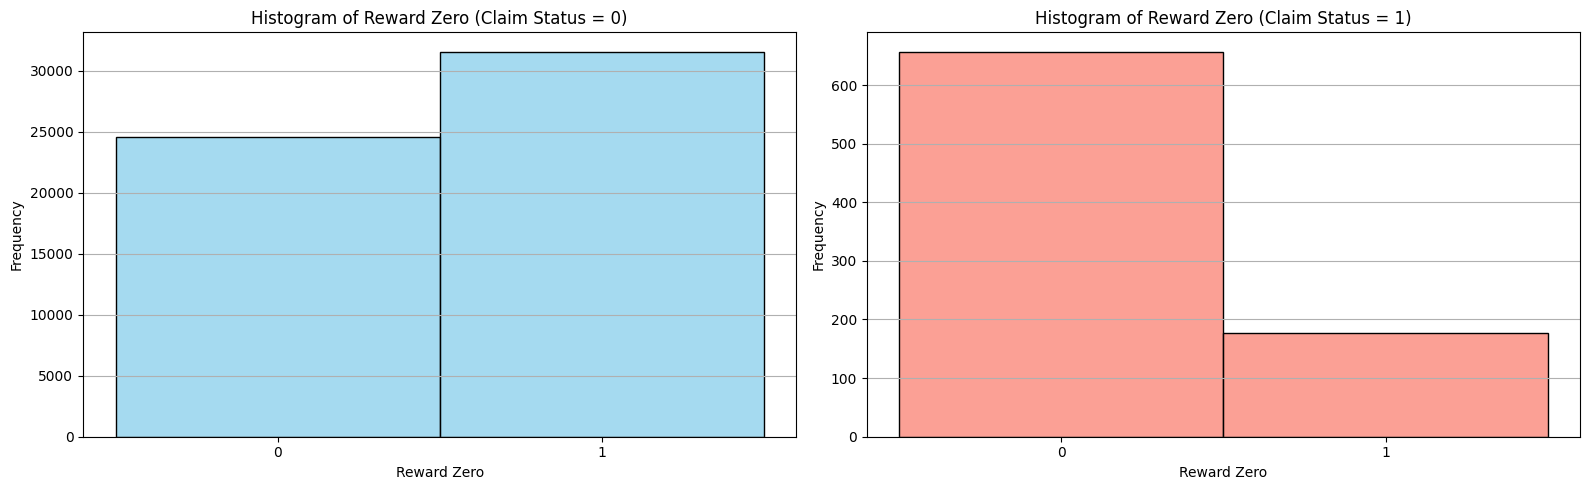

In [14]:
# Creating the binary categorical variable
df['reward_zero'] = df['reward'].apply(lambda x: 1 if x == 0 else 0).astype('category')

# Plot histograms by claim_status
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# For claim_status = 0
sns.histplot(data=df[df['claim_status'] == 0], x='reward_zero', discrete=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Reward Zero (Claim Status = 0)')
axes[0].set_xlabel('Reward Zero')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks([0, 1])
axes[0].grid(axis='y')

# For claim_status = 1
sns.histplot(data=df[df['claim_status'] == 1], x='reward_zero', discrete=True, color='salmon', ax=axes[1])
axes[1].set_title('Histogram of Reward Zero (Claim Status = 1)')
axes[1].set_xlabel('Reward Zero')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


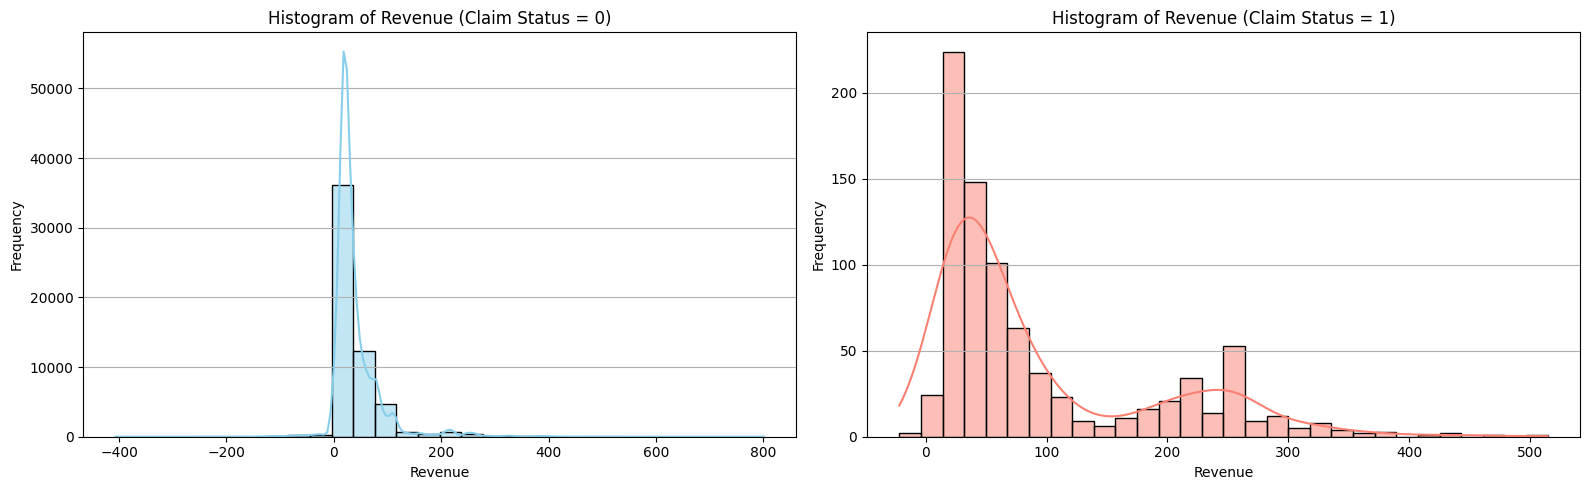

In [15]:
#Revenue values on histogram - 2 separate plots by claim status
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(data=df[df['claim_status'] == 0], x='revenue', bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Revenue (Claim Status = 0)')
axes[0].set_xlabel('Revenue')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

sns.histplot(data=df[df['claim_status'] == 1], x='revenue', bins=30, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Histogram of Revenue (Claim Status = 1)')
axes[1].set_xlabel('Revenue')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

Histograms of Original Revenue
- Histogram of Revenue (Claim Status = 0) (Left - Blue): This distribution is highly concentrated around zero, with a very tall, narrow peak. There are also some negative revenue values, which could represent returns or refunds. The distribution is extremely skewed to the right, with a long tail extending into positive revenue values, but the vast majority of observations are near zero. This suggests that for cases with no claims, most revenue is very low or zero, with a few instances of higher revenue.
- Histogram of Revenue (Claim Status = 1) (Right - Red): This distribution is also right-skewed, but in a different way. It starts at positive revenue values (no negative revenue is visible here), with a peak somewhere around 25-50. It then has a long tail extending to higher revenue values. Compared to 'Claim Status = 0', the 'Claim Status = 1' distribution for revenue is shifted significantly to the right, indicating that when a claim occurs, the associated revenue tends to be positive and generally much higher than for non-claim cases.

C:\Users\wojci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


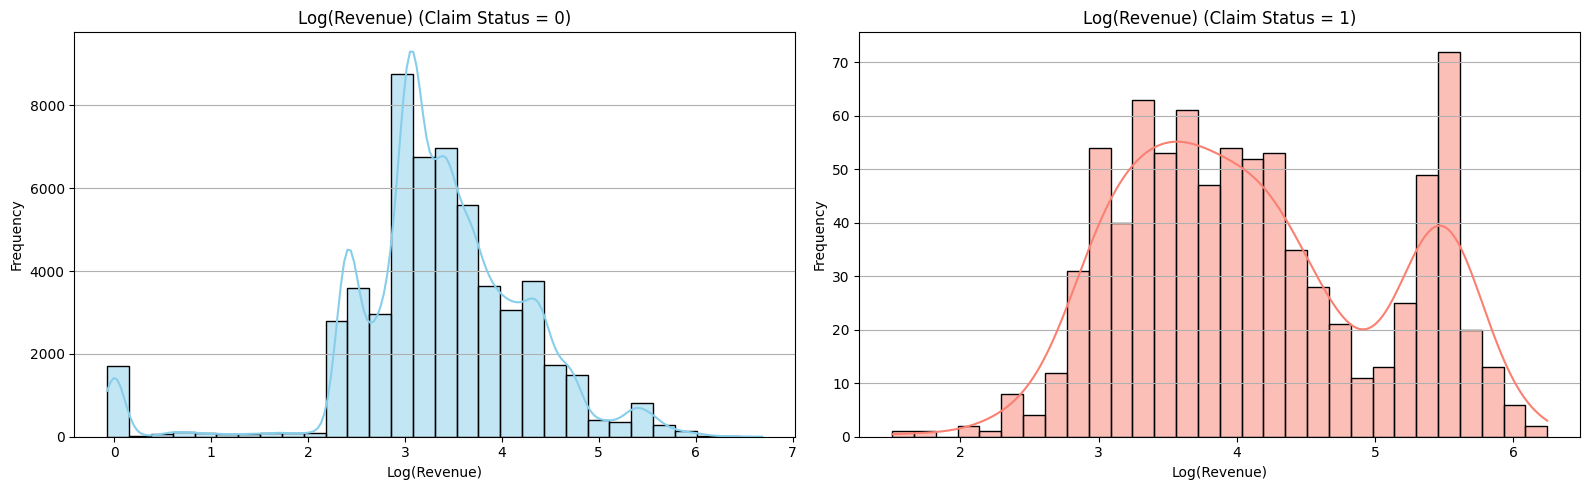

In [16]:
# Log-transformation of 'revenue' column
df['log_revenue'] = np.log((df['revenue'] + 1).replace(0, 0.001)).replace(0, 0.001)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 wiersz, 2 kolumny

sns.histplot(data=df[df['claim_status'] == 0], x='log_revenue', bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Log(Revenue) (Claim Status = 0)')
axes[0].set_xlabel('Log(Revenue)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

sns.histplot(data=df[df['claim_status'] == 1], x='log_revenue', bins=30, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Log(Revenue) (Claim Status = 1)')
axes[1].set_xlabel('Log(Revenue)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

Histograms of Log-Transformed Revenue (Log(Revenue))

- Note: The comment "RuntimeWarning: invalid value encountered in log" indicates that there were non-positive values (zero or negative revenue) in the original data which resulted in NaN or inf values when applying the logarithm, as log is only defined for positive numbers. This is clearly visible in the 'Claim Status = 0' log-transformed histogram with a spike at the far left (likely representing the negative/zero values that couldn't be transformed or were handled as a specific category).
- Log(Revenue) (Claim Status = 0) (Left - Blue): Despite the warning and the spike on the left (which likely corresponds to the non-positive original 'Revenue' values), the bulk of the transformed data shows an improved, more symmetrical distribution compared to the original. It still has some skewness, but it's much better distributed than the highly peaked original.
The peak for the main distribution (excluding the outlier/transformed non-positive values) appears to be around 3.0 to 4.0 on the log scale.
- Log(Revenue) (Claim Status = 1) (Right - Red): The log transformation has made this distribution significantly more symmetrical and somewhat resembles a normal distribution. The extreme right skewness of the original 'Revenue' for 'Claim Status = 1' has been largely mitigated.
The peak of the distribution is around 4.0 to 5.0 on the log scale.

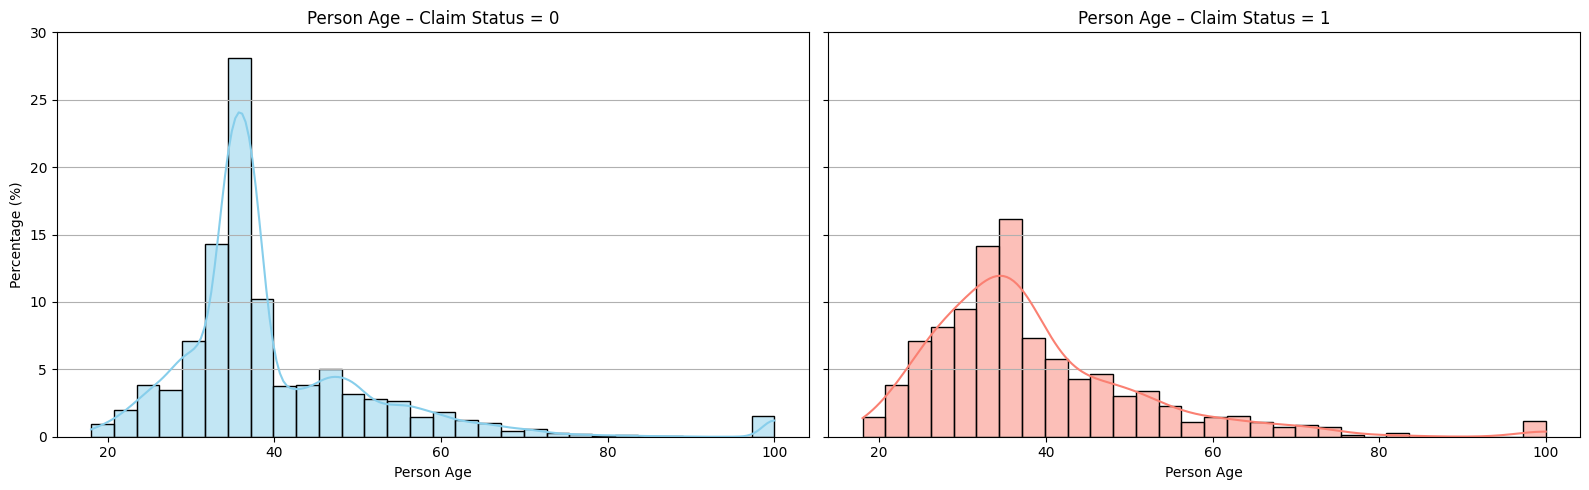

In [17]:
#Age values on histogram - 2 separate plots by claim status
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sns.histplot(
    data=df[df['claim_status'] == 0],
    x='person_age',
    bins=30,
    kde=True,
    color='skyblue',
    stat="percent",
    ax=axes[0]
)
axes[0].set_title('Person Age – Claim Status = 0')
axes[0].set_xlabel('Person Age')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_ylim(0, 30)
axes[0].grid(axis='y')

sns.histplot(
    data=df[df['claim_status'] == 1],
    x='person_age',
    bins=30,
    kde=True,
    color='salmon',
    stat="percent",
    ax=axes[1]
)
axes[1].set_title('Person Age – Claim Status = 1')
axes[1].set_xlabel('Person Age')
axes[1].set_ylabel('')  # Y-axis label shared
axes[1].set_ylim(0, 30)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


Histograms of Original Person Age
- Person Age - Claim Status = 0 (Left - Blue): The distribution of 'Person Age' for non-claims is somewhat right-skewed. There's a peak in the 20s and 30s, and the frequency gradually decreases as age increases.
This suggests that a larger percentage of individuals who do not make claims are younger adults.
- Person Age - Claim Status = 1 (Right - Red): This distribution also appears right-skewed, but with a more pronounced peak around the late 20s to early 40s. The spread seems a bit narrower than 'Claim Status = 0', with fewer individuals in the older age brackets contributing to claims.
While both are skewed, the distribution for 'Claim Status = 1' appears to have a slightly higher concentration of individuals in the younger to middle-aged adult demographic compared to 'Claim Status = 0'.


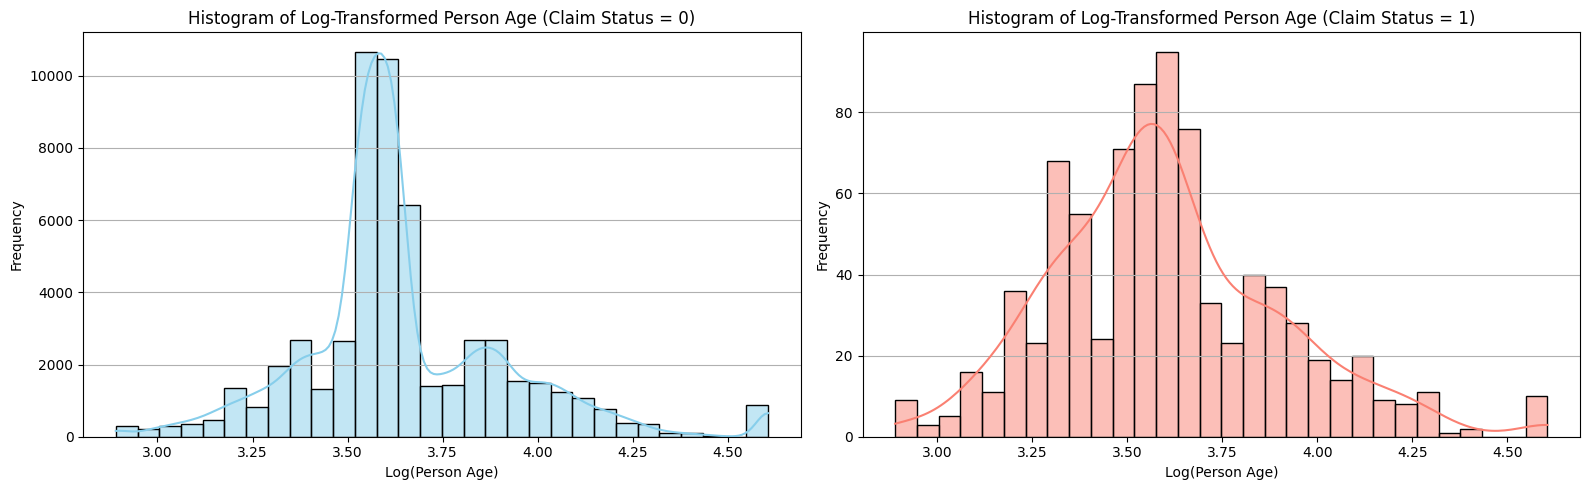

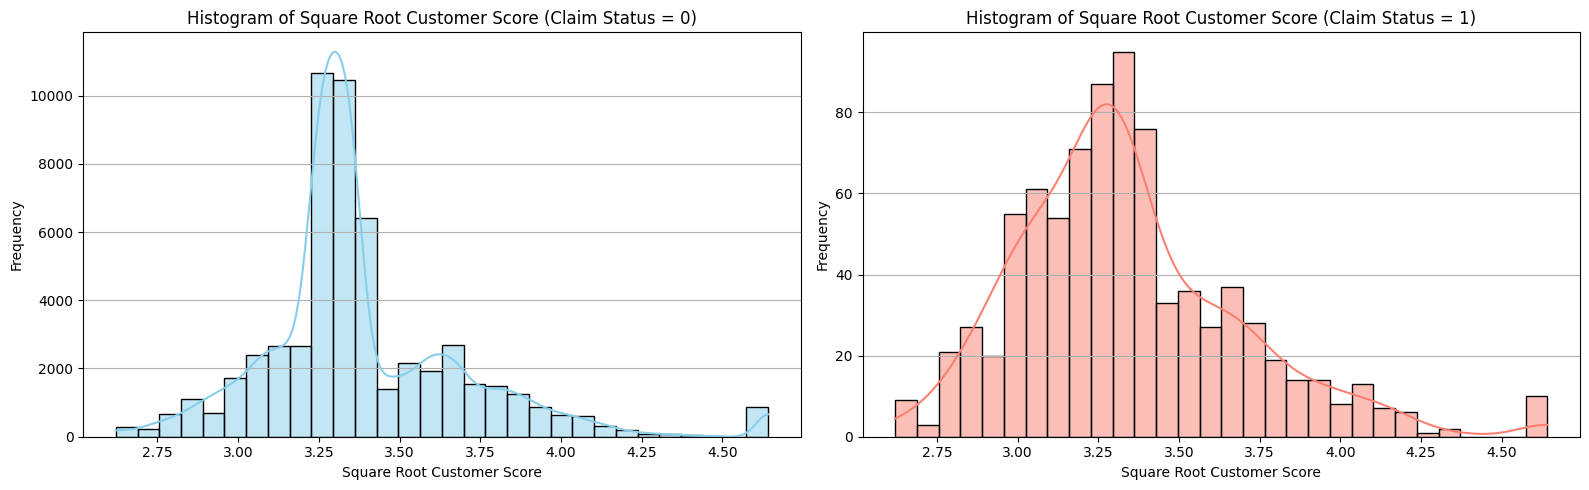

In [18]:
df['log_person_age'] = np.log(df['person_age'])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # bez sharey=True

sns.histplot(data=df[df['claim_status'] == 0], x='log_person_age', bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Log-Transformed Person Age (Claim Status = 0)')
axes[0].set_xlabel('Log(Person Age)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

sns.histplot(data=df[df['claim_status'] == 1], x='log_person_age', bins=30, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Histogram of Log-Transformed Person Age (Claim Status = 1)')
axes[1].set_xlabel('Log(Person Age)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

# Let's make a square root transformation of the person_age variable
df['sqrt_person_age'] = np.cbrt(df['person_age'])
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(
    data=df[df['claim_status'] == 0],
    x='sqrt_person_age',
    bins=30,
    kde=True,
    color='skyblue',
    ax=axes[0]
)
axes[0].set_title('Histogram of Square Root Customer Score (Claim Status = 0)')
axes[0].set_xlabel('Square Root Customer Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')
sns.histplot(
    data=df[df['claim_status'] == 1],
    x='sqrt_person_age',
    bins=30,
    kde=True,
    color='salmon',
    ax=axes[1]
)
axes[1].set_title('Histogram of Square Root Customer Score (Claim Status = 1)')
axes[1].set_xlabel('Square Root Customer Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')
plt.tight_layout()
plt.show()


Histograms of Log-Transformed Person Age (Log(Person Age))
- Histogram of Log-Transformed Person Age (Claim Status = 0) (Left - Blue): Applying a log transformation has effectively made this distribution more symmetrical, resembling a normal (bell-shaped) distribution. This indicates that the original 'Person Age' data for Claim Status = 0 might be approximately log-normally distributed. The x-axis represents 'Log(Person Age)', ranging roughly from 3.0 to 4.5.
- Histogram of Log-Transformed Person Age (Claim Status = 1) (Right - Red): The log transformation has also significantly improved the symmetry of this distribution. It now looks much closer to a normal distribution compared to its original highly skewed form. This suggests that log transformation is an appropriate method to normalize the 'Person Age' variable for both claim statuses, making it more suitable for statistical analyses that assume normality.

Histograms of Square Root Customer Score
- Histogram of Square Root Customer Score (Claim Status = 0) (Left - Blue): The variable here is 'Square Root Customer Score'. The distribution for 'Claim Status = 0' appears quite symmetrical and close to a normal distribution. There's a clear peak around 3.5 on the 'Square Root Customer Score' scale. This suggests that the square root transformation (or perhaps the original 'Customer Score' itself, if it was already squared) has effectively normalized this variable for non-claim individuals.
- Histogram of Square Root Customer Score (Claim Status = 1) (Right - Red):
The distribution of 'Square Root Customer Score' for 'Claim Status = 1' is also relatively symmetrical and appears somewhat normal, though perhaps with a slight tail to the right compared to 'Claim Status = 0'. The peak is also around 3.5, similar to 'Claim Status = 0'.
This indicates that 'Customer Score', once square root transformed, is fairly well-behaved for both claim statuses, showing a similar central tendency and spread.

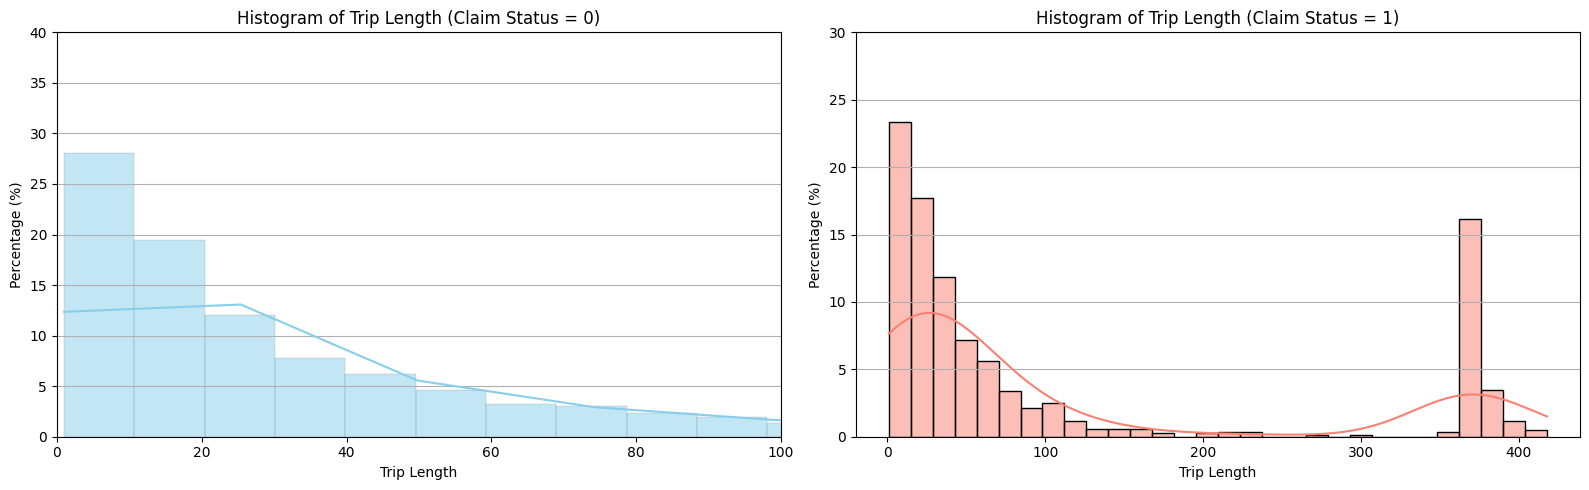

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(
    data=df[df['claim_status'] == 0],
    x='trip_length',
    bins=500,
    kde=True,
    color='skyblue',
    stat="percent",
    ax=axes[0]
)
axes[0].set_title('Histogram of Trip Length (Claim Status = 0)')
axes[0].set_xlabel('Trip Length')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_ylim(0, 40)
axes[0].set_xlim(0, 100)
axes[0].grid(axis='y')

sns.histplot(
    data=df[df['claim_status'] == 1],
    x='trip_length',
    bins=30,
    kde=True,
    color='salmon',
    stat="percent",
    ax=axes[1]
)
axes[1].set_title('Histogram of Trip Length (Claim Status = 1)')
axes[1].set_xlabel('Trip Length')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_ylim(0, 30)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


Histograms of Original Trip Length
- Claim Status = 0 (Left - Blue): The distribution is highly right-skewed. A large percentage of trips are very short (0-20 units), and the frequency drops off significantly as trip length increases. This suggests that most trips for non-claims are short, with fewer very long trips.
- Claim Status = 1 (Right - Red): This distribution also appears right-skewed, but with a more pronounced peak around 400 units. There's a clear concentration of trip lengths at the higher end of the observed range, potentially indicating a truncation or a specific characteristic of trips associated with claims. Comparing to 'Claim Status = 0', the trips associated with claims seem to be significantly longer on average, with a distinct mode at the upper end.

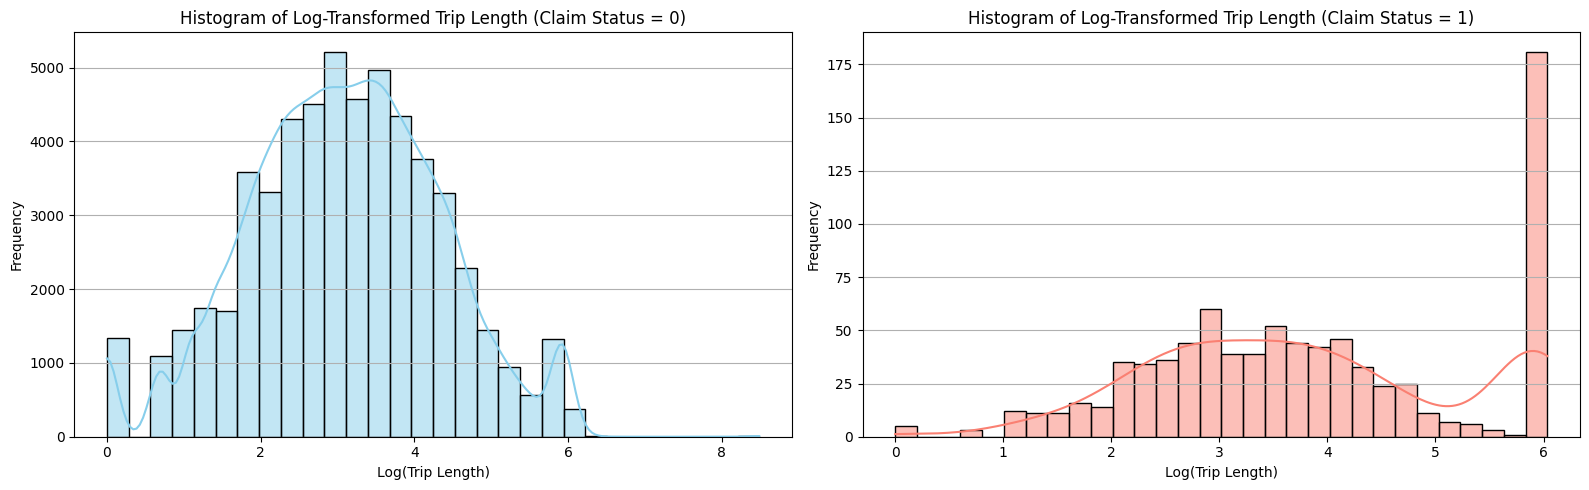

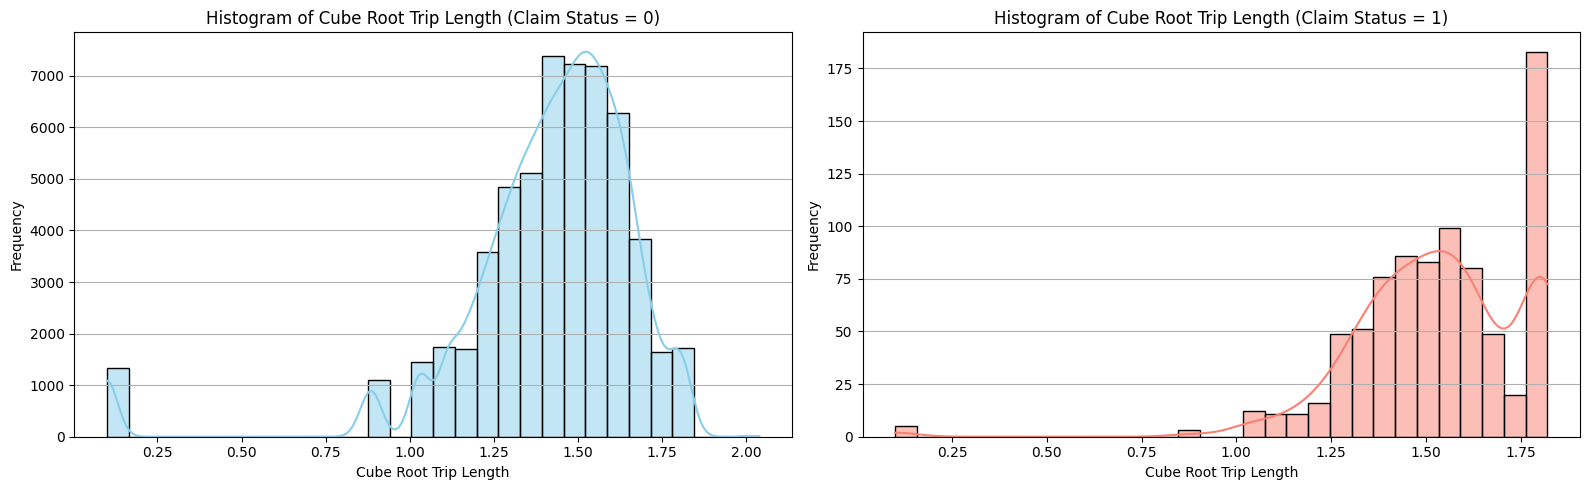

In [20]:
# Logging the trip_length variable
df['log_trip_length'] = np.log(df['trip_length'].replace(0, 0.001)).replace(0, 0.001)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(
    data=df[df['claim_status'] == 0],
    x='log_trip_length',
    bins=30,
    kde=True,
    color='skyblue',
    ax=axes[0]
)
axes[0].set_title('Histogram of Log-Transformed Trip Length (Claim Status = 0)')
axes[0].set_xlabel('Log(Trip Length)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

sns.histplot(
    data=df[df['claim_status'] == 1],
    x='log_trip_length',
    bins=30,
    kde=True,
    color='salmon',
    ax=axes[1]
)
axes[1].set_title('Histogram of Log-Transformed Trip Length (Claim Status = 1)')
axes[1].set_xlabel('Log(Trip Length)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

# Let's make a cube root transformation of the trip_length variable
df['cbrt_trip_length'] = np.cbrt(df['log_trip_length'])
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(
    data=df[df['claim_status'] == 0],
    x='cbrt_trip_length',
    bins=30,
    kde=True,
    color='skyblue',
    ax=axes[0]
)
axes[0].set_title('Histogram of Cube Root Trip Length (Claim Status = 0)')
axes[0].set_xlabel('Cube Root Trip Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')
sns.histplot(
    data=df[df['claim_status'] == 1],
    x='cbrt_trip_length',
    bins=30,
    kde=True,
    color='salmon',
    ax=axes[1]
)
axes[1].set_title('Histogram of Cube Root Trip Length (Claim Status = 1)')
axes[1].set_xlabel('Cube Root Trip Length')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')
plt.tight_layout()
plt.show()


Histograms of Log-Transformed Trip Length (Log(Trip Length))
- Claim Status = 0 (Left - Blue): Applying a log transformation has made the distribution much more symmetrical, resembling a bell curve. This indicates that the original 'Trip Length' data for non-claims was likely log-normally distributed. The x-axis now represents 'Log(Trip Length)', with values ranging from approximately 0 to 8.
- Claim Status = 1 (Right - Red): The log transformation has also helped to normalize this distribution, although it still appears somewhat skewed to the right compared to the left plot in this row. There's a peak around 4.5 to 5 on the log scale, and a significant spike at the far right end (around 6) which corresponds to the spike at 400 in the original scale.
While better distributed, the distinct concentration at the upper end (visible in the original scale) remains as a spike, suggesting a characteristic of claim-related trip lengths that isn't fully normalized by a log transform alone.

Histograms of Cube Root Transformed Trip Length (Cube Root Trip Length)

- Claim Status = 0 (Left - Blue): The cube root transformation has also effectively normalized the distribution, making it appear more symmetrical and bell-shaped than the original data. It looks very similar to the log-transformed version in terms of symmetry. The x-axis now represents 'Cube Root Trip Length', with values mostly between 1 and 2.
- Claim Status = 1 (Right - Red): Similar to the log transformation, the cube root transformation has made the distribution more symmetrical but still retains the prominent spike at the upper end (around 1.75), which corresponds to the 400-unit spike in the original data. The overall shape, excluding the spike, appears more normal than the original, but the extreme values still stand out.

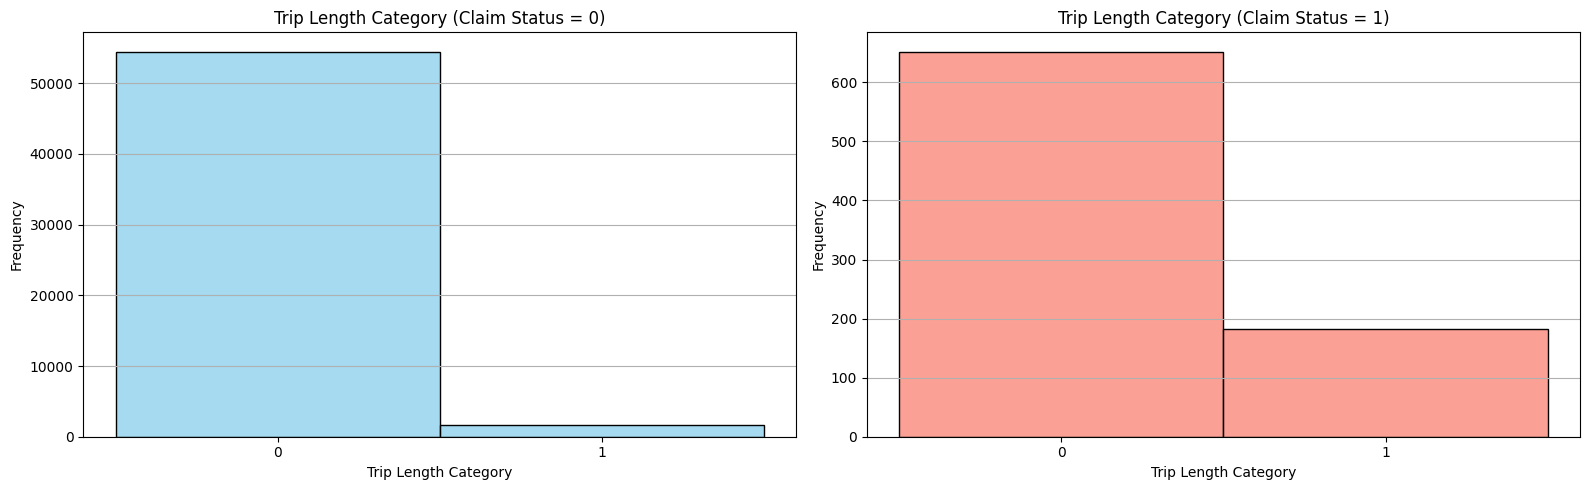

In [21]:
# Let's create a new column for the trip length 2 possibilities category - if trip_length is over 300
df['trip_length_category'] = df['trip_length'].apply(lambda x: 1 if x > 300 else 0).astype('category')

# Plotting the trip_length_category variable
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 2 wykresy obok siebie
sns.histplot(
    data=df[df['claim_status'] == 0],
    x='trip_length_category',
    discrete=True,
    color='skyblue',
    ax=axes[0]
)
axes[0].set_title('Trip Length Category (Claim Status = 0)')
axes[0].set_xlabel('Trip Length Category')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks([0, 1])
axes[0].grid(axis='y')
sns.histplot(
    data=df[df['claim_status'] == 1],
    x='trip_length_category',
    discrete=True,
    color='salmon',
    ax=axes[1]
)
axes[1].set_title('Trip Length Category (Claim Status = 1)')
axes[1].set_xlabel('Trip Length Category')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].grid(axis='y')
plt.tight_layout()
plt.show()

According to the plots above I created a variable indicating whether the trip is longer than 300 days or not. It might be useful in the modeling phase.

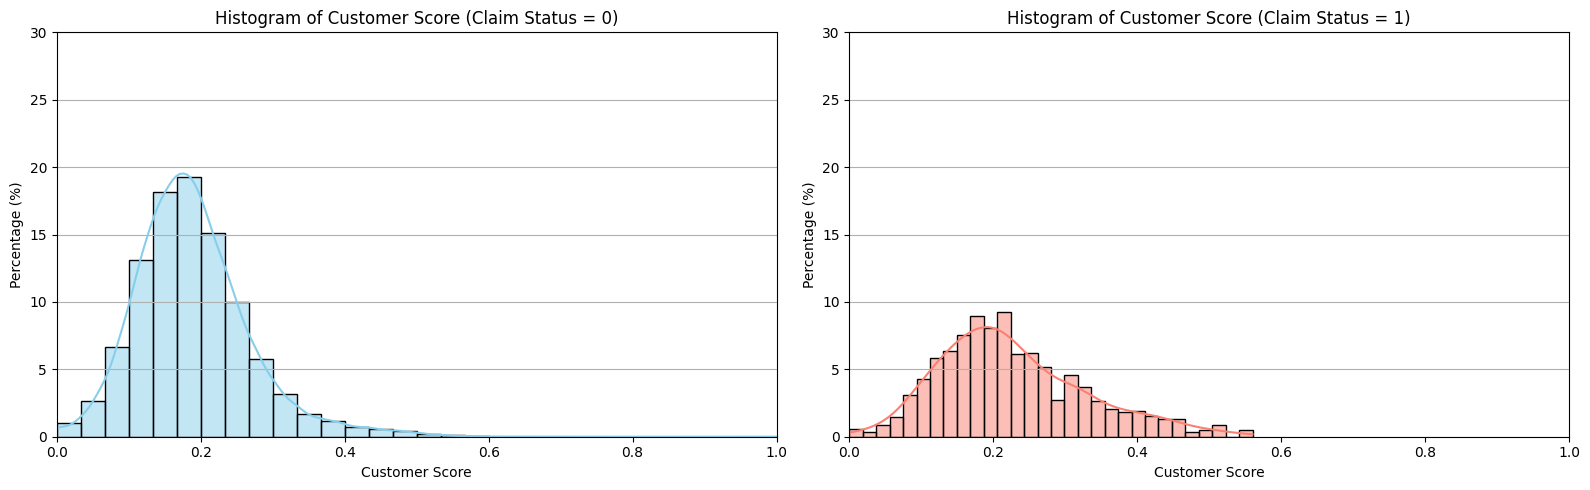

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(
    data=df[df['claim_status'] == 0],
    x='customer_score',
    bins=30,
    kde=True,
    color='skyblue',
    stat="percent",
    ax=axes[0]
)
axes[0].set_title('Histogram of Customer Score (Claim Status = 0)')
axes[0].set_xlabel('Customer Score')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_ylim(0, 30)
axes[0].set_xlim(0, 1)
axes[0].grid(axis='y')

sns.histplot(
    data=df[df['claim_status'] == 1],
    x='customer_score',
    bins=30,
    kde=True,
    color='salmon',
    stat="percent",
    ax=axes[1]
)
axes[1].set_title('Histogram of Customer Score (Claim Status = 1)')
axes[1].set_xlabel('Customer Score')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_ylim(0, 30)
axes[1].set_xlim(0, 1)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


Raw Customer Score:
- Highly right-skewed in both groups, especially for claim = 1.
- Claim = 0 has a tighter, more concentrated distribution around 0.2.
- Claim = 1 is flatter, more spread out, and heavier on the upper tail.

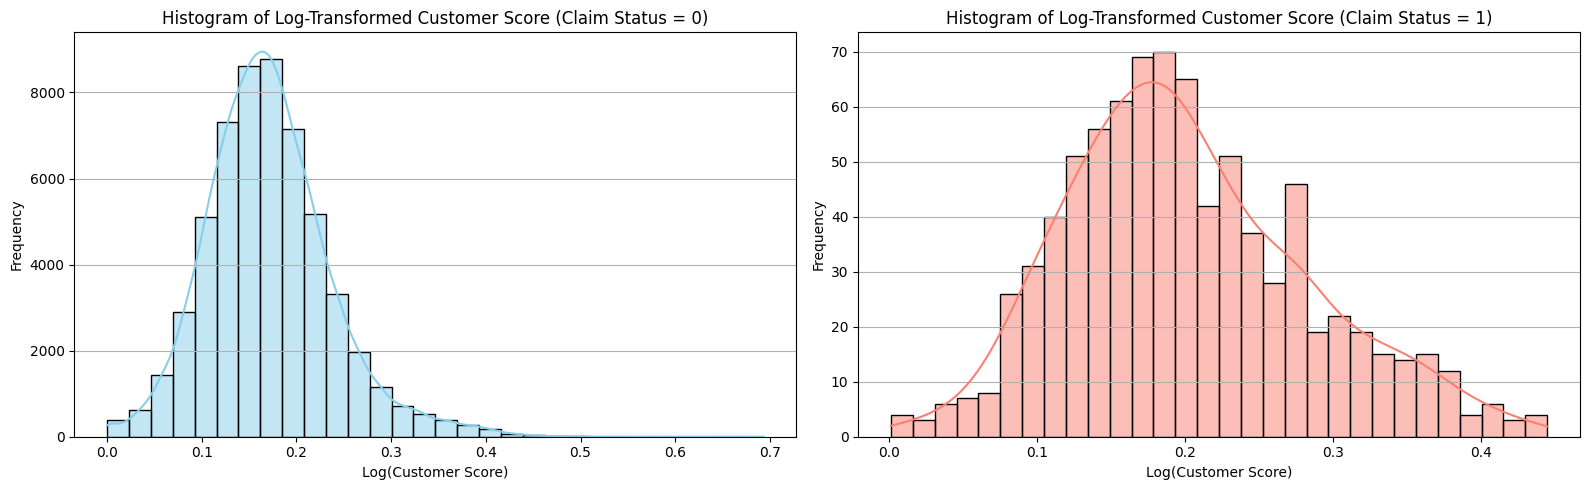

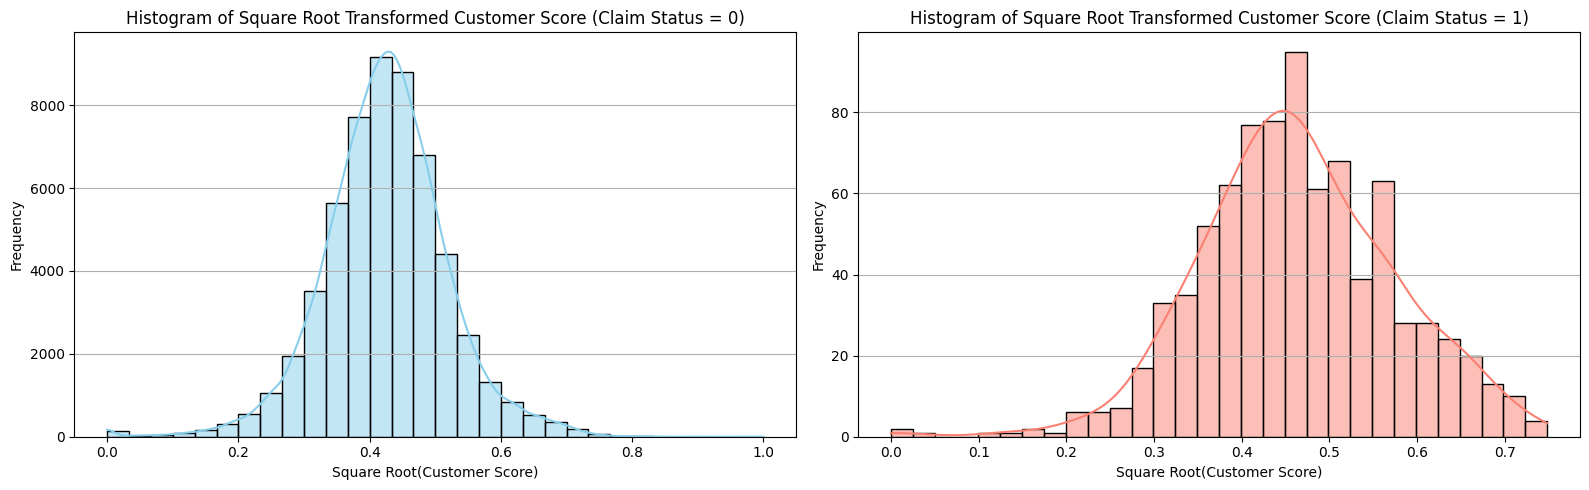

In [23]:
# Logging the customer_score variable
df['log_customer_score'] = np.log((df['customer_score']+1).replace(0, 0.001)).replace(0, 0.001)
# Plotting the log-transformed variable - separate plots by claim status
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(
    data=df[df['claim_status'] == 0],
    x='log_customer_score',
    bins=30,
    kde=True,
    color='skyblue',
    ax=axes[0]
)
axes[0].set_title('Histogram of Log-Transformed Customer Score (Claim Status = 0)')
axes[0].set_xlabel('Log(Customer Score)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

sns.histplot(
    data=df[df['claim_status'] == 1],
    x='log_customer_score',
    bins=30,
    kde=True,
    color='salmon',
    ax=axes[1]
)
axes[1].set_title('Histogram of Log-Transformed Customer Score (Claim Status = 1)')
axes[1].set_xlabel('Log(Customer Score)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

#Lets try to make a square root transformation of the customer_score variable
df['sqrt_customer_score'] = np.sqrt(df['customer_score'])
# Plotting the square root transformed variable - separate plots by claim status
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(
    data=df[df['claim_status'] == 0],
    x='sqrt_customer_score',
    bins=30,
    kde=True,
    color='skyblue',
    ax=axes[0]
)
axes[0].set_title('Histogram of Square Root Transformed Customer Score (Claim Status = 0)')
axes[0].set_xlabel('Square Root(Customer Score)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')
sns.histplot(
    data=df[df['claim_status'] == 1],
    x='sqrt_customer_score',
    bins=30,
    kde=True,
    color='salmon',
    ax=axes[1]
)
axes[1].set_title('Histogram of Square Root Transformed Customer Score (Claim Status = 1)')
axes[1].set_xlabel('Square Root(Customer Score)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')
plt.tight_layout()
plt.show()


Log-Transformed Customer Score:
- For claim = 0, the distribution is close to normal.
- For claim = 1, the distribution is more irregular and slightly right-skewed — some evidence of better separation between groups after transformation.

Square Root Transformed Customer Score:
- Both groups show more symmetric, bell-shaped distributions.
- Slightly better normalization than log, but separation between claim groups remains modest.

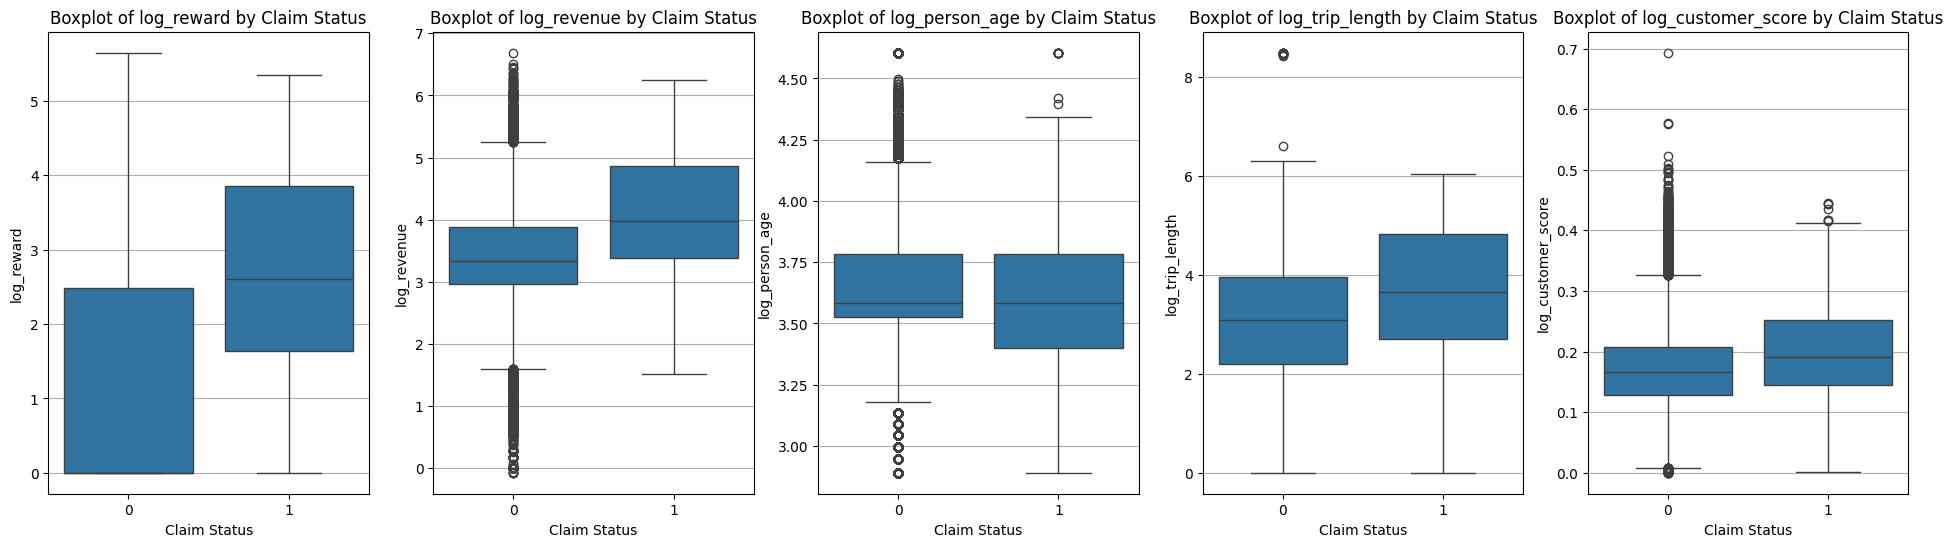

In [24]:
# Boxplots for numerical variables
def plot_boxplot(df, col, ax):
    sns.boxplot(x='claim_status', y=col, data=df, ax=ax)
    ax.set_title(f'Boxplot of {col} by Claim Status')
    ax.set_xlabel('Claim Status')
    ax.set_ylabel(col)
    ax.grid(axis='y')

fig, axes = plt.subplots(1, 5, figsize=(24, 6))
plot_boxplot(df, 'log_reward', axes[0])
plot_boxplot(df, 'log_revenue', axes[1])
plot_boxplot(df, 'log_person_age', axes[2])
plot_boxplot(df, 'log_trip_length', axes[3])
plot_boxplot(df, 'log_customer_score', axes[4])


- For Log(Reward) Claims (status = 1) are associated with higher median rewards and a broader range. No-claim group shows a much lower median and many observations near zero. Reward appears to be positively associated with claim occurrence.
- In case of Log(Revenue) the median revenue is higher for the claim group. Distribution is wider and more right-skewed for claims. Like rewards, higher revenue seems linked with claims.
- For Log(Person Age) both groups have similar distributions, though the no-claim group has more extreme outliers (older or younger travelers). Age likely has little influence on claim status
- For Log(Trip Length) claims are associated with slightly longer trips on average. Distributions overlap, but the claim group skews higher. Trip length may be a weak predictor.
- For Log(Customer Score) distributions are very similar between both groups. Slight increase in median for claims, but not substantial. Customer score does not appear to differentiate between claim statuses.

To sum up Reward and Revenue are likely the most informative features for predicting claim status in this dataset. Age, trip length, and especially customer score show weak or minimal differences.

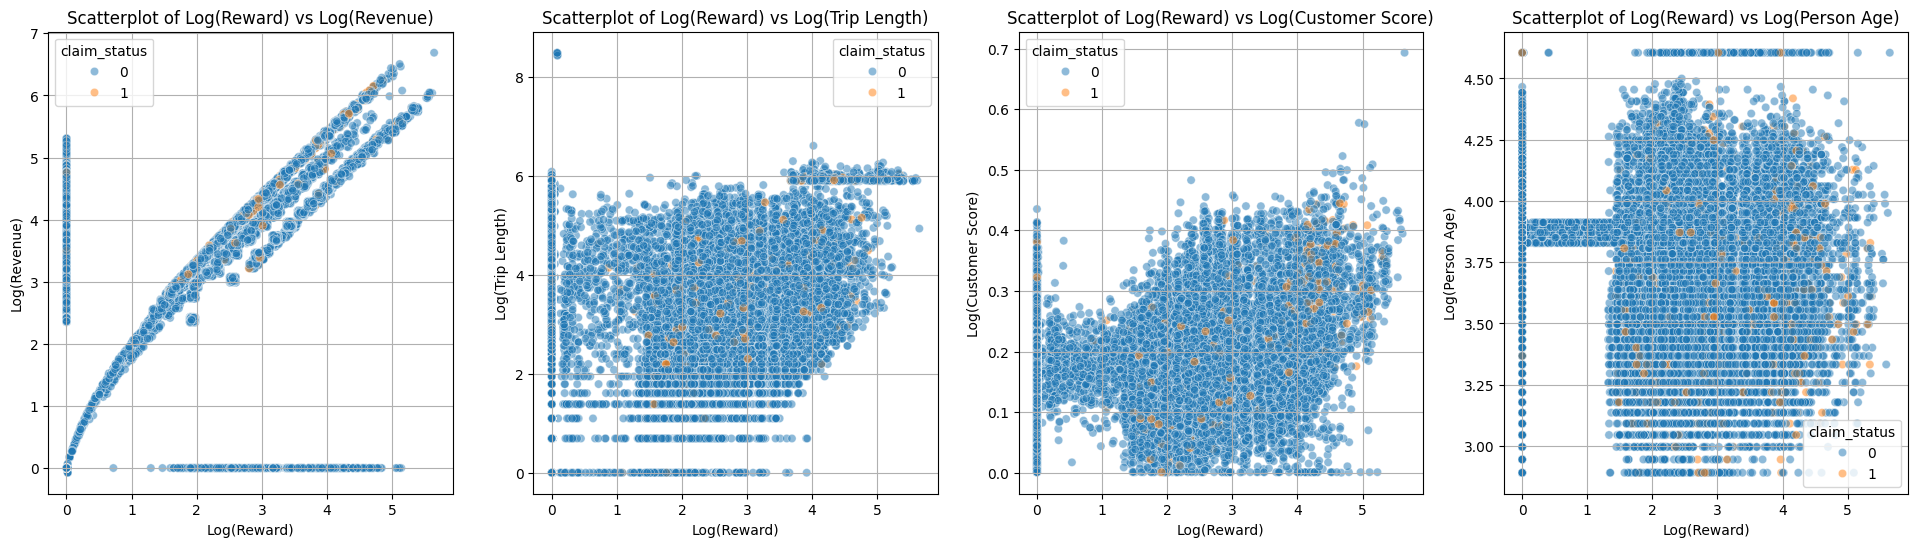

In [25]:
#Scatterplot for log_reward and log_revenue
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
sns.scatterplot(data=df, x='log_reward', y='log_revenue', hue='claim_status', alpha=0.5, ax=axes[0])
axes[0].set_title('Scatterplot of Log(Reward) vs Log(Revenue)')
axes[0].set_xlabel('Log(Reward)')
axes[0].set_ylabel('Log(Revenue)')
axes[0].grid()

#Scatterplot for log_reward and log_trip_length
sns.scatterplot(data=df, x='log_reward', y='log_trip_length', hue='claim_status', alpha=0.5, ax=axes[1])
axes[1].set_title('Scatterplot of Log(Reward) vs Log(Trip Length)')
axes[1].set_xlabel('Log(Reward)')
axes[1].set_ylabel('Log(Trip Length)')
axes[1].grid()
#Scatterplot for log_reward and log_customer_score
sns.scatterplot(data=df, x='log_reward', y='log_customer_score', hue='claim_status', alpha=0.5, ax=axes[2])
axes[2].set_title('Scatterplot of Log(Reward) vs Log(Customer Score)')
axes[2].set_xlabel('Log(Reward)')
axes[2].set_ylabel('Log(Customer Score)')
axes[2].grid()

#Scatterplot for log_reward and log_person_age
sns.scatterplot(data=df, x='log_reward', y='log_person_age', hue='claim_status', alpha=0.5, ax=axes[3])
axes[3].set_title('Scatterplot of Log(Reward) vs Log(Person Age)')
axes[3].set_xlabel('Log(Reward)')
axes[3].set_ylabel('Log(Person Age)')
axes[3].grid()


These scatterplots show the relationships between Log(Reward) and other log-transformed variables, colored by claim_status (0 = no claim, 1 = claim submitted).
- Log(Revenue) shows a strong positive correlation with Log(Reward), indicating that higher revenue is closely tied to higher rewards. This is the clearest relationship among the plots.
- Log(Trip Length) and Log(Customer Score) display weaker, more scattered relationships with Log(Reward). Data points are dense in some areas, but no strong trend emerges.
- Log(Person Age) shows little to no visible correlation with Log(Reward); most data is concentrated within a narrow age range.

Claims (orange dots) appear infrequently and are dispersed throughout the plots, without clear patterns—suggesting that claim likelihood is not directly linked to any single variable and may require more complex modeling to predict.

#### Categorical Variables

To create groups for categories fist we will need to check which unique values we have in each column.

In [26]:
#All products in the dataset
all_products = df['product_id'].unique()
print("All products:")
print(all_products)

All products:
['SecurePlan Flex' 'DriveSafe Rental Addon' 'TripGuard Cancel'
 'SecurePlan OneWay' 'TravelShield Basic' 'TravelShield Core'
 'TravelShield Plus' 'TravelShield Value' 'SecurePlan Annual Lite'
 'TripGuard TicketCover' 'CruiseSafe Trip' 'QuickProtect 24'
 'SecurePlan Standard' 'SecurePlan Individual' 'TripGuard Plus'
 'TravelShield Premium' 'TripGuard Pro' 'TripGuard Max'
 'TripGuard Annual Lite' 'TravelShield Elite' 'TravelShield Annual Pro'
 'TripGuard Annual Pro' 'TripGuard Annual Max' 'SecurePlan Family'
 'CruiseSafe Family' 'SecurePlan Junior']


In [27]:
#All countries in the dataset
all_countries = df['location'].unique()
print("All countries:")
print(all_countries)

All countries:
['united states' 'spain' 'new zealand' 'thailand' 'viet nam' 'australia'
 'croatia' 'malaysia' 'indonesia' 'singapore' 'brazil' 'china'
 'taiwan, province of china' 'cambodia' 'india' 'finland' 'philippines'
 'myanmar' 'united arab emirates' 'hong kong' 'united kingdom' 'japan'
 'netherlands' 'sri lanka' 'switzerland' 'brunei darussalam'
 'korea, republic of' 'austria' 'turkey' 'france' 'denmark'
 'russian federation' 'greece' 'romania' 'germany' 'canada' 'israel'
 'bangladesh' 'macao' 'peru' 'mongolia' "lao people's democratic republic"
 'kenya' 'cyprus' 'nepal' 'ukraine' 'ethiopia' 'serbia' 'uganda' 'italy'
 'portugal' 'belgium' 'sweden' 'qatar' 'maldives' 'pakistan' 'colombia'
 'bahrain' 'mexico' 'saudi arabia' 'jordan' 'south africa' 'norway' 'fiji'
 'iceland' 'kuwait' 'namibia' 'uzbekistan' 'poland' 'morocco' 'zambia'
 'azerbaijan' 'puerto rico' 'czech republic' 'ireland' 'kazakhstan'
 'reunion' 'vanuatu' 'guam' 'hungary' 'georgia' 'egypt'
 'tanzania, united republi

In case of categorical variables I decided to prepair a function to plot them all at one. I decided to follow the same path of two plots for each parameter: for claim_status = 0 and claim_status = 1. I also decided to do plotting of Top 10, and put rest in the "Other" category.


Analiza zmiennej: person_gender


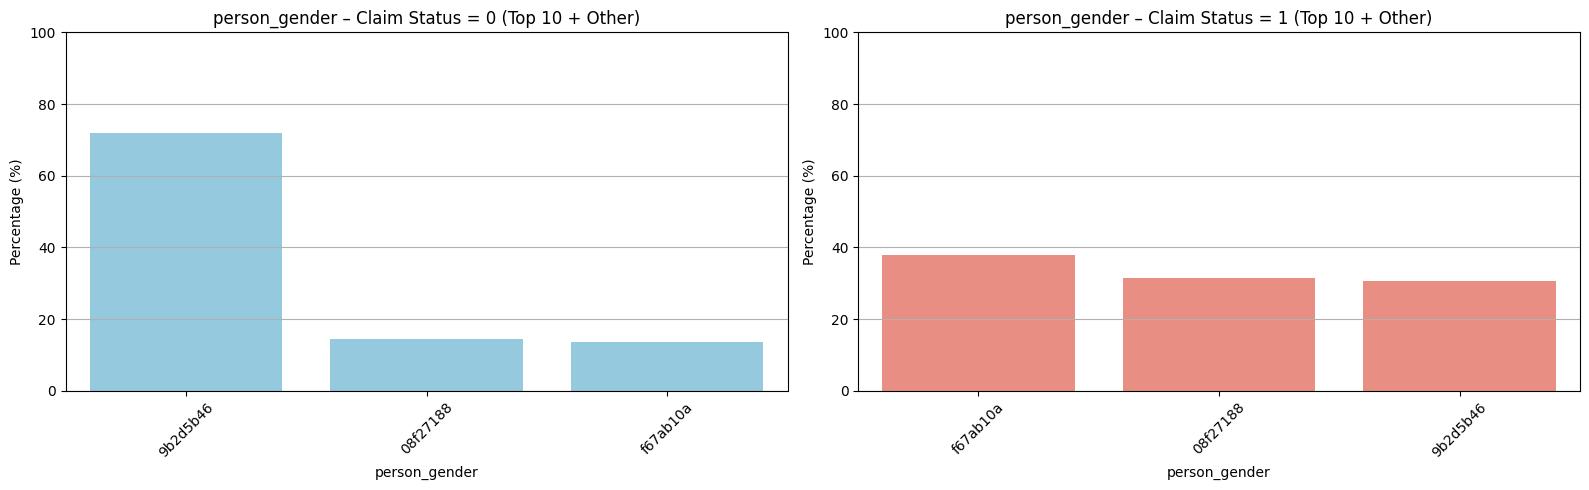

Distribution of person_gender (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
person_gender,,
9b2d5b46,40387,71.92
08f27188,8117,14.45
f67ab10a,7655,13.63
,Count,Percentage
person_gender,,
f67ab10a,316,37.89
08f27188,262,31.41
9b2d5b46,256,30.70



Analiza zmiennej: entity_type


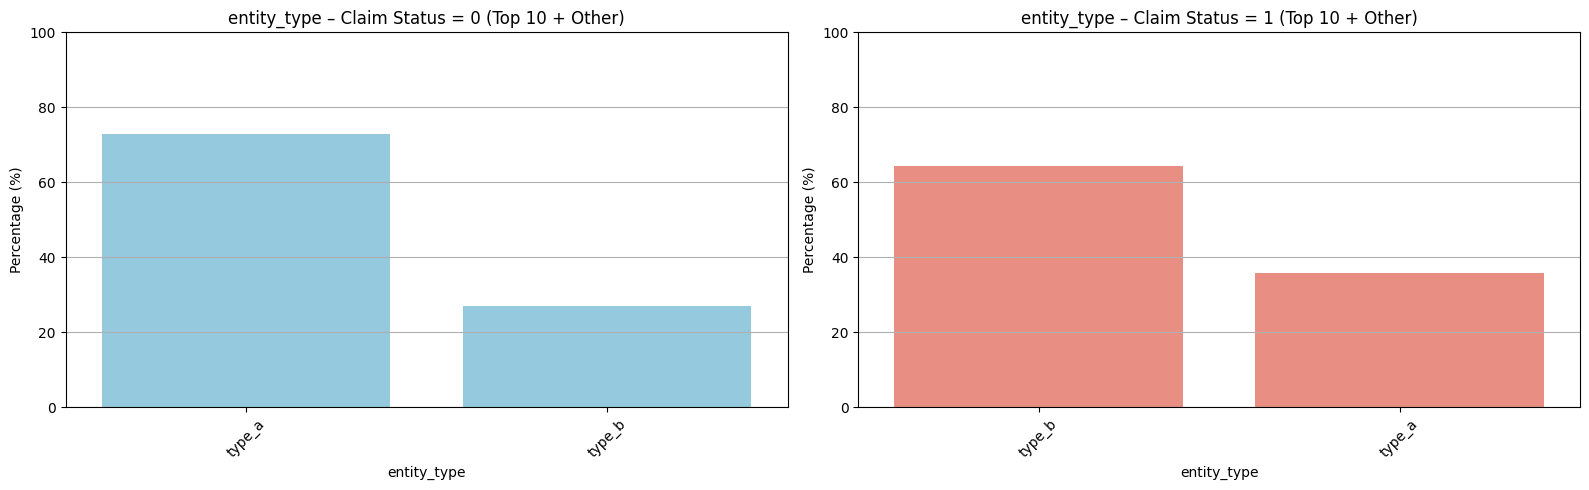

Distribution of entity_type (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
entity_type,,
type_a,40999,73.01
type_b,15160,26.99
,Count,Percentage
entity_type,,
type_b,536,64.27
type_a,298,35.73



Analiza zmiennej: channel


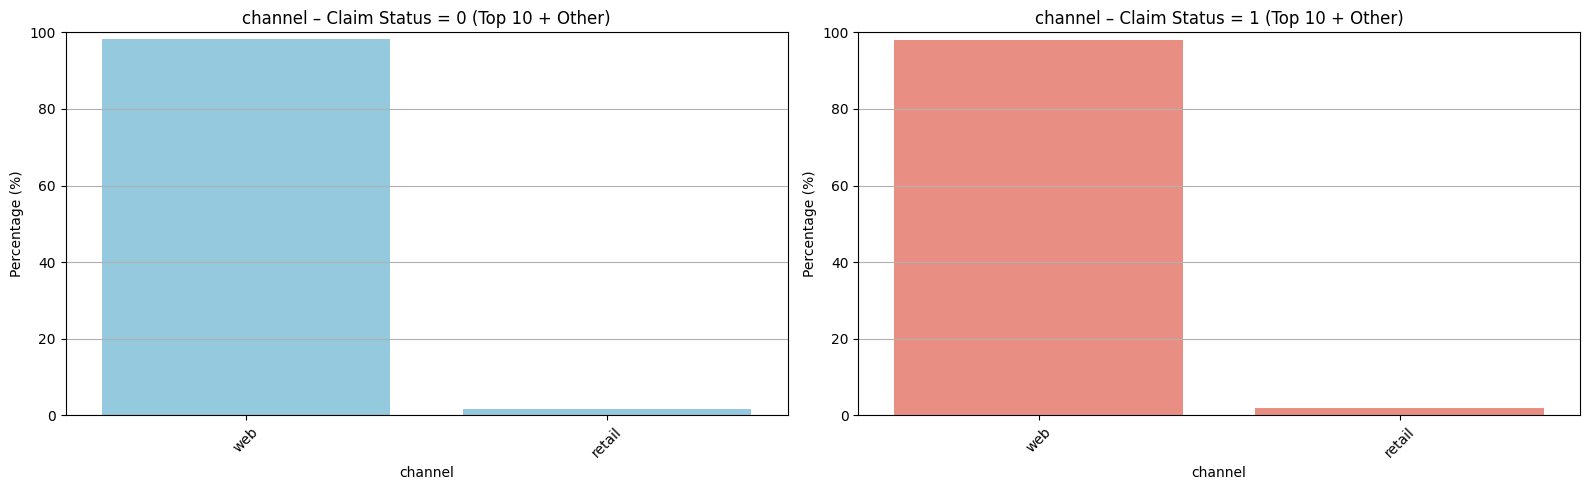

Distribution of channel (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
channel,,
web,55201,98.29
retail,958,1.71
,Count,Percentage
channel,,
web,818,98.08
retail,16,1.92



Analiza zmiennej: support_interactions


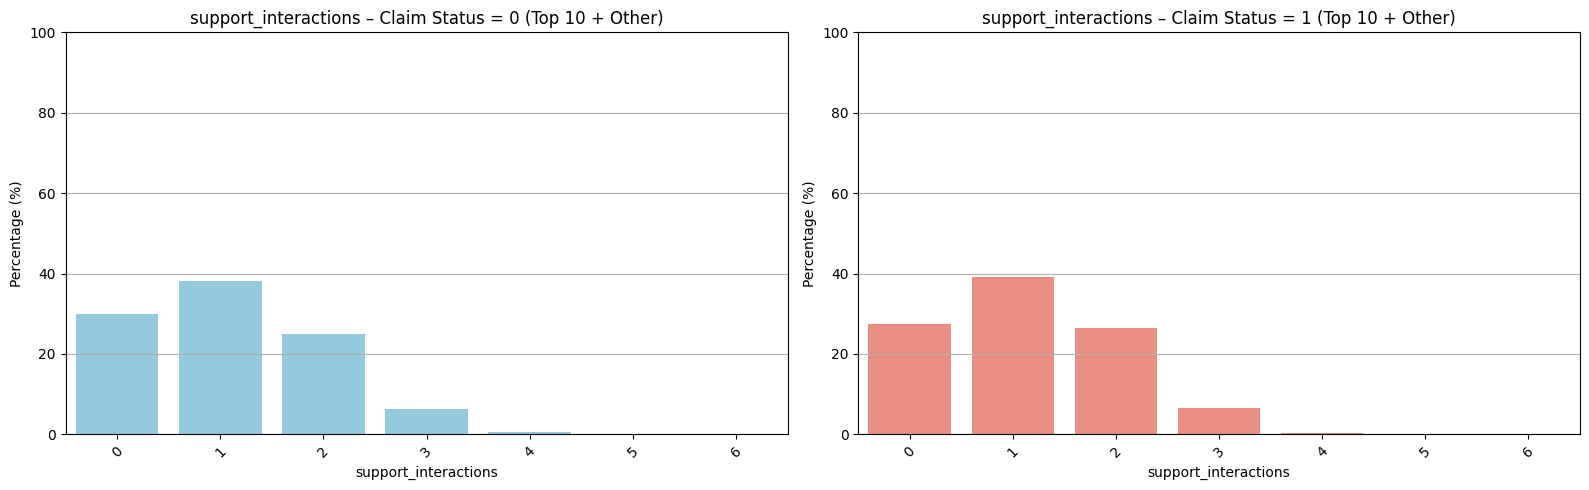

Distribution of support_interactions (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
support_interactions,,
1,21408,38.12
0,16885,30.07
2,13995,24.92
3,3490,6.21
4,366,0.65
5,14,0.02
6,1,0.00
,Count,Percentage
support_interactions,,



Analiza zmiennej: agent_id


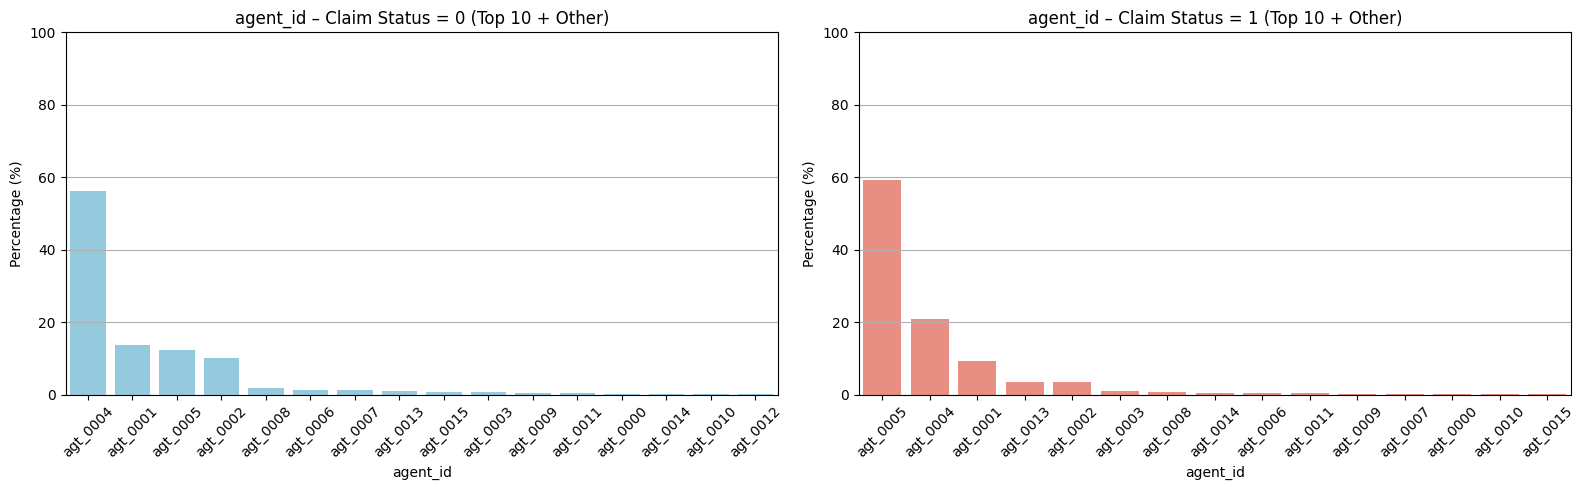

Distribution of agent_id (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
agent_id,,
agt_0004,31490,56.07
agt_0001,7636,13.60
agt_0005,6950,12.38
agt_0002,5653,10.07
agt_0008,943,1.68
Other,784,1.40
agt_0006,668,1.19
agt_0007,650,1.16
agt_0013,582,1.04



Analiza zmiennej: entity_a


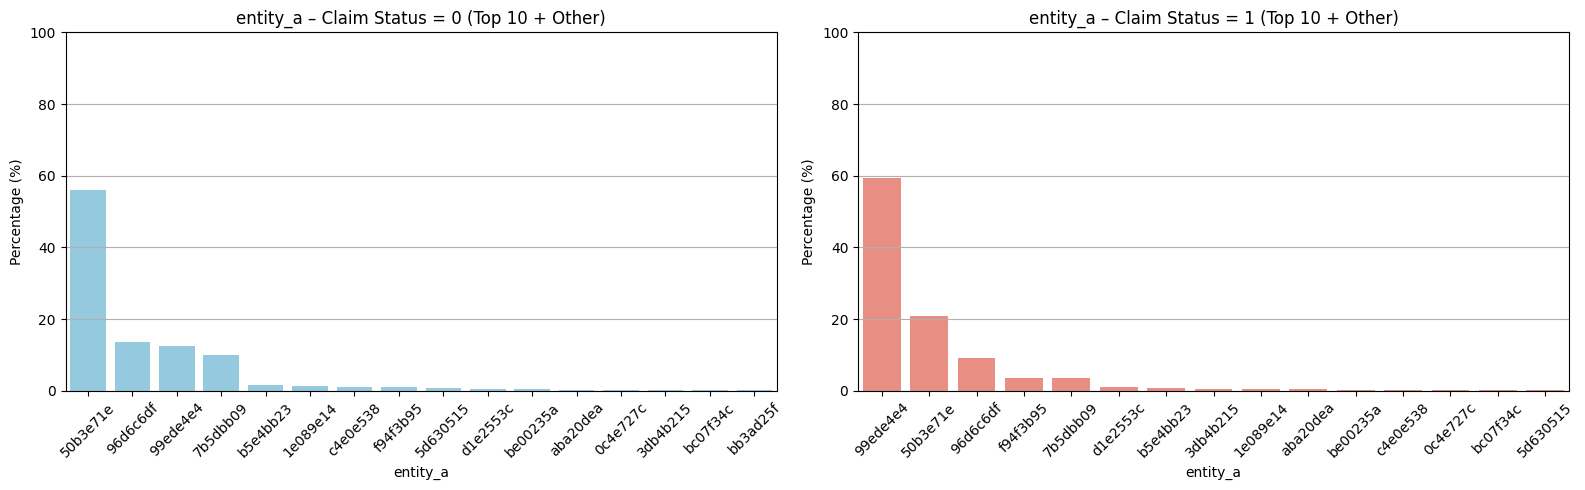

Distribution of entity_a (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
entity_a,,
50b3e71e,31490,56.07
96d6c6df,7636,13.60
99ede4e4,6950,12.38
7b5dbb09,5653,10.07
b5e4bb23,943,1.68
Other,784,1.40
1e089e14,668,1.19
c4e0e538,650,1.16
f94f3b95,582,1.04



Analiza zmiennej: location


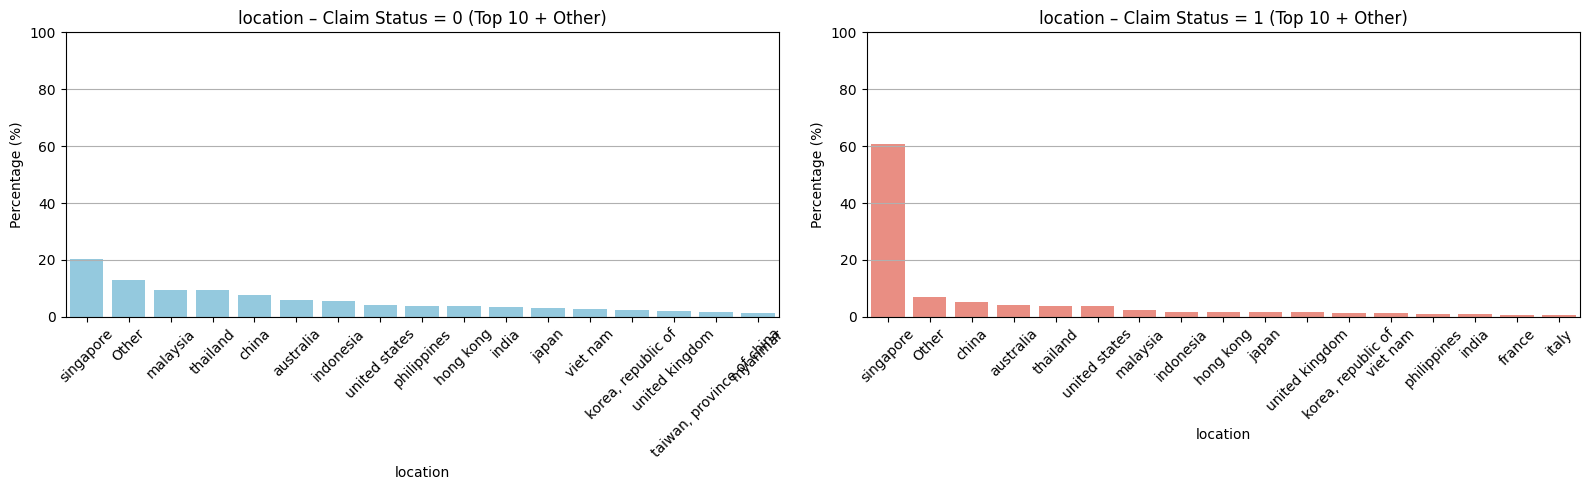

Distribution of location (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
location,,
Other,14755,26.27
singapore,11436,20.36
malaysia,5335,9.50
thailand,5271,9.39
china,4301,7.66
australia,3289,5.86
indonesia,3092,5.51
united states,2267,4.04
philippines,2232,3.97



Analiza zmiennej: product_id


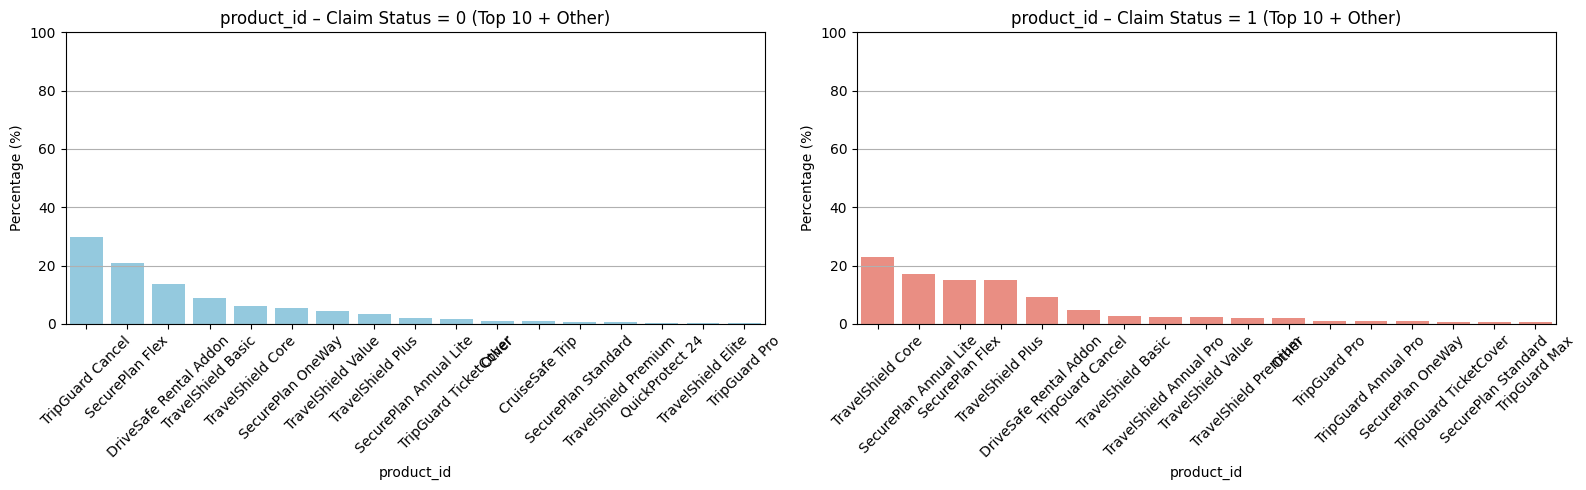

Distribution of product_id (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
product_id,,
TripGuard Cancel,16755,29.83
SecurePlan Flex,11747,20.92
DriveSafe Rental Addon,7636,13.60
TravelShield Basic,4892,8.71
TravelShield Core,3446,6.14
SecurePlan OneWay,2988,5.32
TravelShield Value,2413,4.30
Other,2293,4.08
TravelShield Plus,1907,3.40



Analiza zmiennej: reward_zero


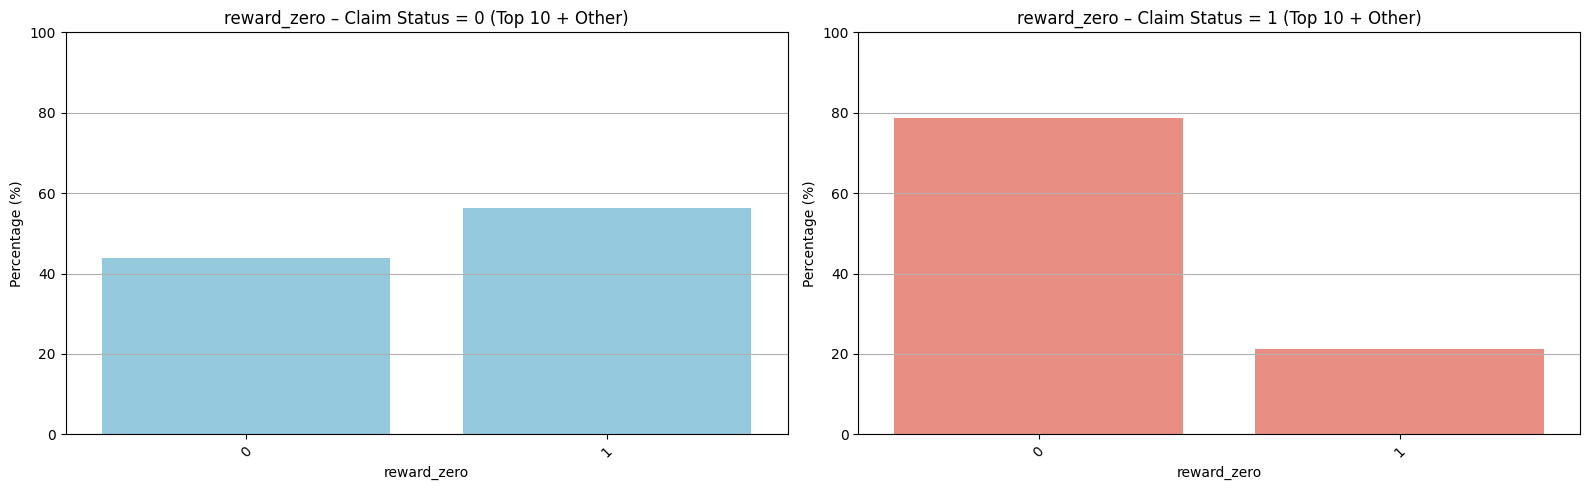

Distribution of reward_zero (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
reward_zero,,
1,31571,56.22
0,24588,43.78
,Count,Percentage
reward_zero,,
0,657,78.78
1,177,21.22



Analiza zmiennej: trip_length_category


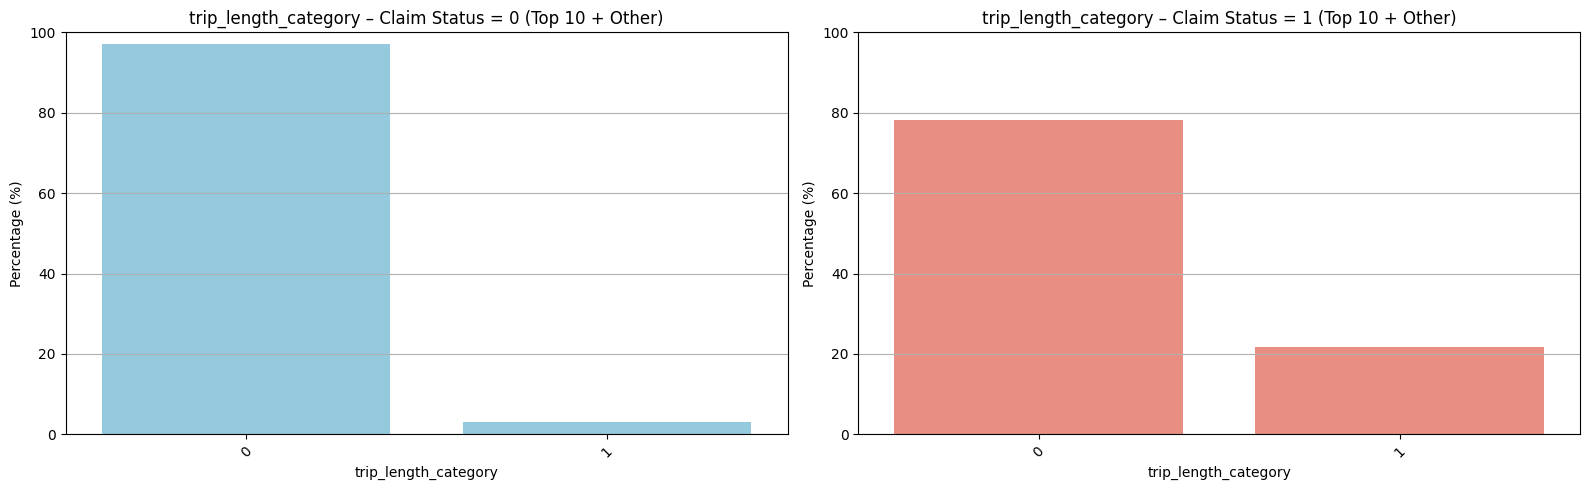

Distribution of trip_length_category (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
trip_length_category,,
0,54479,97.01
1,1680,2.99
,Count,Percentage
trip_length_category,,
0,652,78.18
1,182,21.82



Analiza zmiennej: region


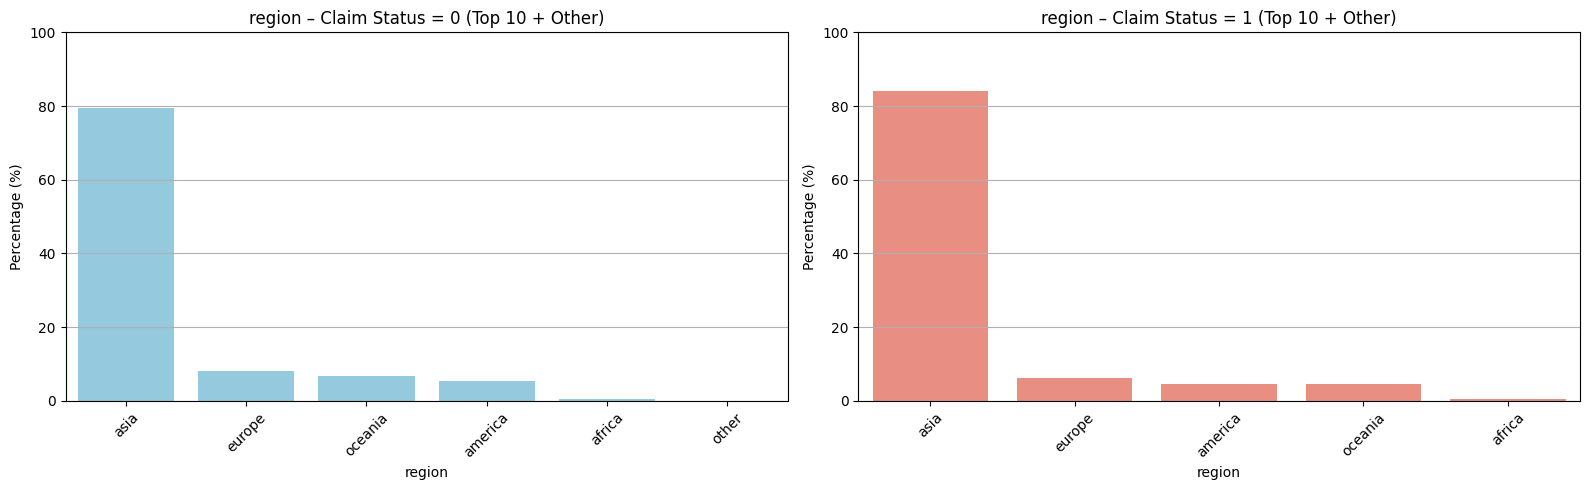

Distribution of region (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
region,,
asia,44571,79.37
europe,4510,8.03
oceania,3806,6.78
america,2975,5.30
africa,266,0.47
other,31,0.06
,Count,Percentage
region,,
asia,701,84.05



Analiza zmiennej: product_category


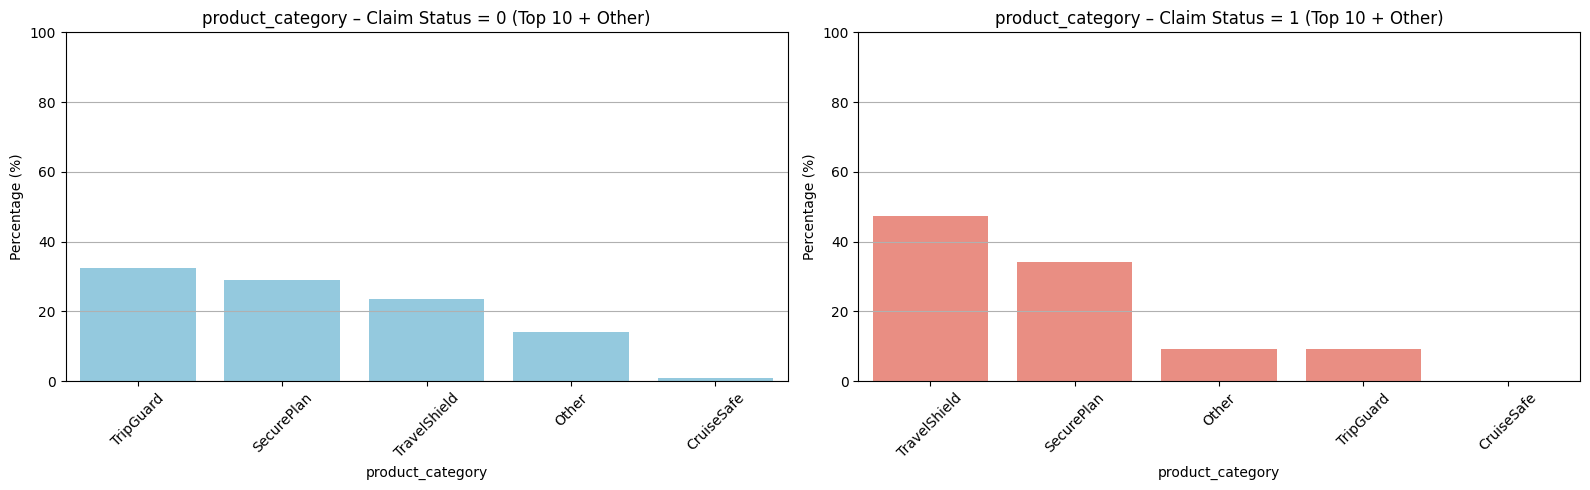

Distribution of product_category (Claim Status = 0) and (Claim Status = 1):


,Count,Percentage
product_category,,
TripGuard,18280,32.55
SecurePlan,16276,28.98
TravelShield,13291,23.67
Other,7857,13.99
CruiseSafe,455,0.81
,Count,Percentage
product_category,,
TravelShield,395,47.36
SecurePlan,285,34.17


In [28]:
df['support_interactions'] = df['support_interactions'].astype('category')
# Function to map country names to regions
def map_country_to_region(country):
    europe = [
        'spain', 'croatia', 'finland', 'united kingdom', 'netherlands', 'switzerland',
        'france', 'denmark', 'russian federation', 'greece', 'romania', 'germany',
        'cyprus', 'ukraine', 'serbia', 'italy', 'portugal', 'belgium', 'sweden',
        'norway', 'austria', 'iceland', 'poland', 'czech republic', 'ireland',
        'republic of montenegro', 'slovenia', 'malta', 'lithuania', 'latvia',
        'macedonia, the former yugoslav republic of', 'albania', 'luxembourg',
        'estonia', 'hungary', 'bulgaria', 'belarus', 'bosnia and herzegovina'
    ]
    
    asia = [
        'thailand', 'viet nam', 'malaysia', 'indonesia', 'singapore', 'china',
        'taiwan, province of china', 'cambodia', 'india', 'philippines', 'myanmar',
        'united arab emirates', 'hong kong', 'japan', 'sri lanka', 'brunei darussalam',
        'korea, republic of', 'turkey', 'israel', 'bangladesh', 'macao', 'mongolia',
        "lao people's democratic republic", 'nepal', 'pakistan', 'qatar', 'maldives',
        'bahrain', 'saudi arabia', 'jordan', 'uzbekistan', 'kazakhstan', 'azerbaijan',
        'georgia', 'lebanon', 'kyrgyzstan', 'tunisia', 'tibet', 'iran, islamic republic of',
        'bhutan', 'tajikistan', 'armenia', 'turkmenistan'
    ]
    
    oceania = [
        'australia', 'new zealand', 'fiji', 'vanuatu', 'guam', 'solomon islands',
        'french polynesia', 'new caledonia', 'samoa', 'papua new guinea'
    ]
    
    america = [
        'united states', 'brazil', 'canada', 'peru', 'colombia', 'mexico',
        'puerto rico', 'argentina', 'costa rica', 'bolivia', 'venezuela', 'guadeloupe',
        'bermuda', 'panama', 'jamaica', 'trinidad and tobago', 'dominican republic',
        'ecuador', 'northern mariana islands', 'guatemala', 'cayman islands',
        'barbados', 'uruguay', 'chile', 'virgin islands, u.s.'
    ]
    
    africa = [
        'kenya', 'morocco', 'zambia', 'ghana', 'ethiopia', 'uganda', 'nigeria',
        'namibia', 'south africa', 'tanzania, united republic of', 'egypt',
        'cameroon', 'zimbabwe', 'senegal', 'mauritius', 'botswana', 'mali',
        'angola', 'sierra leone', 'guinea', 'guinea-bissau', 'rwanda'
    ]
    
    other = [
        'reunion', 'macedonia, the former yugoslav republic of', 'moldova, republic of'
    ]
    
    if country in europe:
        return 'europe'
    elif country in asia:
        return 'asia'
    elif country in oceania:
        return 'oceania'
    elif country in america:
        return 'america'
    elif country in africa:
        return 'africa'
    else:
        return 'other'

df['region'] = df['location'].str.lower().map(map_country_to_region)

# Function to map product names to categories

def map_product_to_category(product_name):
    # Define all product categories and their members
    secure_plan = [
        'SecurePlan Flex',
        'SecurePlan OneWay',
        'SecurePlan Annual Lite',
        'SecurePlan Standard',
        'SecurePlan Individual',
        'SecurePlan Family',
        'SecurePlan Junior'
    ]
    
    travel_shield = [
        'TravelShield Basic',
        'TravelShield Core',
        'TravelShield Plus',
        'TravelShield Value',
        'TravelShield Premium',
        'TravelShield Elite',
        'TravelShield Annual Pro'
    ]
    
    trip_guard = [
        'TripGuard Cancel',
        'TripGuard TicketCover',
        'TripGuard Plus',
        'TripGuard Pro',
        'TripGuard Max',
        'TripGuard Annual Lite',
        'TripGuard Annual Pro',
        'TripGuard Annual Max'
    ]
    
    cruise_safe = [
        'CruiseSafe Trip',
        'CruiseSafe Family'
    ]
    
    other_products = [
        'DriveSafe Rental Addon',
        'QuickProtect 24'
    ]
    
    # Map the product to its category
    if product_name in secure_plan:
        return 'SecurePlan'
    elif product_name in travel_shield:
        return 'TravelShield'
    elif product_name in trip_guard:
        return 'TripGuard'
    elif product_name in cruise_safe:
        return 'CruiseSafe'
    elif product_name in other_products:
        return 'Other'
    else:
        return 'Unknown'  # For any unexpected products

df['product_category'] = df['product_id'].apply(map_product_to_category)
object_cols = df.select_dtypes(include=['object', 'category']).columns

#Plotting the distribution of categorical variables (Top 10) by claim status

for col in object_cols:
    print(f"\n{'='*40}\nAnaliza zmiennej: {col}\n{'='*40}")

    def prepare_top10_other(series):
        top16 = series.value_counts(normalize=True).nlargest(16)
        mask = series.isin(top16.index)
        result = series.where(mask, other='Other')
        return result

    data0 = prepare_top10_other(df[df['claim_status'] == 0][col])
    data0_counts = data0.value_counts(normalize=True).mul(100).sort_values(ascending=False)

    data1 = prepare_top10_other(df[df['claim_status'] == 1][col])
    data1_counts = data1.value_counts(normalize=True).mul(100).sort_values(ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    sns.barplot(x=data0_counts.index, y=data0_counts.values, color='skyblue', ax=axes[0])
    axes[0].set_title(f'{col} – Claim Status = 0 (Top 10 + Other)')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Percentage (%)')
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y')
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(x=data1_counts.index, y=data1_counts.values, color='salmon', ax=axes[1])
    axes[1].set_title(f'{col} – Claim Status = 1 (Top 10 + Other)')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Percentage (%)')
    axes[1].set_ylim(0, 100)
    axes[1].grid(axis='y')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    def value_counts_top10_other(series):
        top10 = series.value_counts(normalize=False).nlargest(10)
        mask = series.isin(top10.index)
        grouped = series.where(mask, other='Other')
        counts = grouped.value_counts()
        percents = grouped.value_counts(normalize=True) * 100
        return pd.DataFrame({'Count': counts, 'Percentage': percents.round(2)})

    table0 = value_counts_top10_other(df[df['claim_status'] == 0][col])
    table1 = value_counts_top10_other(df[df['claim_status'] == 1][col])

    print(f"Distribution of {col} (Claim Status = 0) and (Claim Status = 1):")
    display(HTML(f"""
    <table>
        <tr>
            <td style="vertical-align:top; padding-right: 30px;">
                <b>Claim Status = 0</b><br>{table0.to_html()}
            </td>
            <td style="vertical-align:top;">
                <b>Claim Status = 1</b><br>{table1.to_html()}
            </td>
        </tr>
    </table>
    """))


person_gender variable analysis
- Claim Status = 0 (No Claim):
The dominant gender is '9b2d5b46' (71.92%), followed by '08f27188' (14.45%) and 'f67ab10a' (13.63%).
This shows a clear majority for one gender in non-claim cases.
- Claim Status = 1 (Claim):
The distribution is more balanced. 'f67ab10a' becomes the most frequent (37.89%), followed by '08f27188' (31.41%) and '9b2d5b46' (30.70%).
- person_gender appears to be a good differentiating factor. The gender that is dominant in non-claim cases (9b2d5b46) is significantly less represented in claim cases, while 'f67ab10a' and '08f27188' are relatively more prominent in claims. This suggests that certain genders are more prone to making claims.

entity_type variable analysis
- Claim Status = 0 (No Claim):
type_a is the most common entity type (73.01%), followed by type_b (26.99%).
- Claim Status = 1 (Claim):
type_b becomes the majority (64.27%), while type_a is less common (35.73%).
- entity_type is a very strong differentiating feature. type_a entities rarely result in claims, while type_b entities are disproportionately associated with claims. This is a highly predictive variable.

channel variable analysis
- Claim Status = 0 (No Claim):
web is overwhelmingly dominant (98.29%), with retail being very rare (1.71%).
- Claim Status = 1 (Claim):
web remains dominant (98.08%), and retail is still very rare (1.92%).
- channel appears to have almost no discriminatory power between claim statuses. The distribution of channels is virtually identical for both claims and no-claims. This variable might not be very useful for prediction.

support_interactions variable analysis

- Claim Status = 0 (No Claim):
The majority of cases have 1 support interaction (38.12%), followed by 0 (30.07%) and 2 (24.92%). Higher numbers of interactions are rare.
- Claim Status = 1 (Claim):
The highest frequency is for 1 interaction (39.21%), then 0 (27.58%), and 2 (26.50%). The distribution looks quite similar to 'Claim Status = 0', but with slightly higher percentages for 0 and 2 interactions for claims.
- The distribution of support_interactions is very similar across both claim statuses. While there might be subtle differences (e.g., slightly higher proportion of 0 and 2 interactions for claims), it's not a strong distinguishing feature on its own. This aligns with the weak correlation observed earlier (0.0042).

agent_id variable analysis

- Claim Status = 0 (No Claim):
agt_0004 is the most frequent (56.07%), followed by agt_0001 (13.60%), agt_0002 (10.07%), and others.
- Claim Status = 1 (Claim):
agt_0005 is the most frequent (59.23%), followed by agt_0004 (20.74%), agt_0001 (9.23%), and agt_0013 (3.60%).
- agent_id is a significant differentiating factor. The top agent for non-claims (agt_0004) still appears in claims, but a different agent (agt_0005) dominates the claim cases. This suggests that certain agents might be associated with a higher likelihood of claims, or the type of policies they sell lead to claims. This variable could be quite predictive.

entity_a variable analysis

- Claim Status = 0 (No Claim):
5d0b371e is the most frequent (56.07%), followed by 9b6d6c9f (13.60%), 69501238 (12.38%), etc.
- Claim Status = 1 (Claim):
996de4e is the most frequent (59.23%), followed by 5d0b371e (20.74%), 9b6d6c9f (9.23%), etc.
- entity_a (likely representing the selling agency) is a strong differentiator. Similar to agent_id, certain entities are disproportionately associated with claims. The dominant entity for non-claims (5d0b371e) is still present in claims, but a different entity (996de4e) is far more prevalent in claim cases. This variable will likely be very important for the model.

location variable analysis

- Claim Status = 0 (No Claim):
other is the most common (26.27%), followed by singapore (20.36%), malaysia (9.50%), thailand (9.39%), etc.
- Claim Status = 1 (Claim):
singapore is overwhelmingly dominant (60.67%), followed by other (12.95%), china (5.28%), etc.
- location is an extremely powerful predictor. 'Singapore' which is a significant location for non-claims, becomes overwhelmingly dominant for claims. This implies that claims are highly concentrated in specific locations, with Singapore being a major hotspot. This variable will be highly influential in the model.

product_id variable analysis

- Claim Status = 0:
The most common product ID is TripGuard Cancel, accounting for approximately 29.83% of instances.
This is followed by SecurePlan Flex (20.92%) and DriveSafe Rental Addiction (13.60%).
Other notable product IDs include TravelShield Basic (8.71%) and TravelShield Core (6.14%).
- Claim Status = 1:
The product ID distribution shifts significantly. TravelShield Core is the most frequent, at 22.90%.
SecurePlan Annual Lite follows with 17.15%.
SecurePlan Flex (14.99%) and TravelShield Plus (14.87%) are also prominent.
DriveSafe Rental Addiction drops to 9.23%.
- The specific insurance product (product_id) appears to be a strong indicator of claim likelihood. Products like TripGuard Cancel are overwhelmingly associated with no claims, while products like TravelShield Core and SecurePlan Annual Lite have a considerably higher representation among claims.

reward_zero variable analysis (this variable determines whether reward = 0 or not)

- Claim Status = 0:
The value 1 for reward_zero is more common, occurring in 56.22% of cases.
The value 0 for reward_zero occurs in 43.78% of cases.
- Claim Status = 1:
The distribution is inverted compared to no claims. The value 0 for reward_zero is overwhelmingly common, found in 78.78% of claims.
The value 1 for reward_zero is present in only 21.22% of claims.
- reward_zero shows a strong association with claim status. A reward_zero value of 0 significantly increases the likelihood of a claim being filed, while a value of 1 is more associated with no claims.

product_category variable analysis (this variable was created basing on product_id variable)

- Claim Status = 0:
TripGuard is the largest category, with 32.55%.
SecurePlan is next at 28.98%.
TravelShield accounts for 23.67%.
Other makes up 13.99%, and CruiseSafe is minimal (0.81%).
- Claim Status = 1:
TravelShield becomes the dominant category, representing 47.36% of claims.
SecurePlan is the second most common, with 34.17%.
The proportion of TripGuard drops significantly to 9.11%.
Other represents 9.23%, and CruiseSafe remains very low (0.12%).
- The product category is also a significant factor. Policies in the TravelShield category have a much higher representation among claims, while TripGuard policies are more common among those with no claims. SecurePlan maintains a substantial presence in both groups but sees a relative increase in its share of claims.

region variable analysis (this variable was created basing on location variable)

- Claim Status = 0:
Asia is by far the most dominant region, accounting for 79.37% of policies with no claims.
Europe follows distantly with 8.03%.
Oceania (6.78%) and America (5.30%) have smaller shares.
Africa (0.47%) and Other (0.06%) are negligible.
- Claim Status = 1:
Asia remains the overwhelmingly dominant region, its share slightly increasing to 84.05%.
Europe's share decreases slightly to 6.12%.
America (4.68%) and Oceania (4.56%) also see slight decreases in their relative proportions.
Africa (0.60%) remains very low.
- While Asia is the predominant region for both policies with and without claims, its dominance is even more pronounced among claims. The other regions constitute a small minority in both cases. This suggests that while most transactions (and claims) originate from Asia, the regional variable itself might offer less distinct predictive power for distinguishing claims from non-claims outside of this general skew, compared to variables like product_id or reward_zero. However, the slight increase in Asia's proportion for claims is noted.

## FEATURE ENGINEERING

#### Grouping categorical variables

In [29]:
# Load data
df = pd.read_csv(f"{raw_input_data_path}/insurance_train.csv")

# Data transformations

def map_country_to_region(country):
    """
    Categorizes countries into geographic regions.
    
    Args:
        country (str): Country name to be categorized
        
    Returns:
        str: Region name (europe, asia, oceania, america, africa, other)
    """
    # Define country groupings by region
    europe = [
        'spain', 'croatia', 'finland', 'united kingdom', 'netherlands', 'switzerland',
        'france', 'denmark', 'russian federation', 'greece', 'romania', 'germany',
        'cyprus', 'ukraine', 'serbia', 'italy', 'portugal', 'belgium', 'sweden',
        'norway', 'austria', 'iceland', 'poland', 'czech republic', 'ireland',
        'republic of montenegro', 'slovenia', 'malta', 'lithuania', 'latvia',
        'macedonia, the former yugoslav republic of', 'albania', 'luxembourg',
        'estonia', 'hungary', 'bulgaria', 'belarus', 'bosnia and herzegovina'
    ]
    
    asia = [
        'thailand', 'viet nam', 'malaysia', 'indonesia', 'china',
        'taiwan, province of china', 'cambodia', 'india', 'philippines', 'myanmar',
        'united arab emirates', 'hong kong', 'japan', 'sri lanka', 'brunei darussalam',
        'korea, republic of', 'turkey', 'israel', 'bangladesh', 'macao', 'mongolia',
        "lao people's democratic republic", 'nepal', 'pakistan', 'qatar', 'maldives',
        'bahrain', 'saudi arabia', 'jordan', 'uzbekistan', 'kazakhstan', 'azerbaijan',
        'georgia', 'lebanon', 'kyrgyzstan', 'tunisia', 'tibet', 'iran, islamic republic of',
        'bhutan', 'tajikistan', 'armenia', 'turkmenistan', 'singapore'
    ]
    
    oceania = [
        'australia', 'new zealand', 'fiji', 'vanuatu', 'guam', 'solomon islands',
        'french polynesia', 'new caledonia', 'samoa', 'papua new guinea'
    ]
    
    america = [
        'united states', 'brazil', 'canada', 'peru', 'colombia', 'mexico',
        'puerto rico', 'argentina', 'costa rica', 'bolivia', 'venezuela', 'guadeloupe',
        'bermuda', 'panama', 'jamaica', 'trinidad and tobago', 'dominican republic',
        'ecuador', 'northern mariana islands', 'guatemala', 'cayman islands',
        'barbados', 'uruguay', 'chile', 'virgin islands, u.s.'
    ]
    
    africa = [
        'kenya', 'morocco', 'zambia', 'ghana', 'ethiopia', 'uganda', 'nigeria',
        'namibia', 'south africa', 'tanzania, united republic of', 'egypt',
        'cameroon', 'zimbabwe', 'senegal', 'mauritius', 'botswana', 'mali',
        'angola', 'sierra leone', 'guinea', 'guinea-bissau', 'rwanda'
    ]

    other = [
        'reunion', 'macedonia, the former yugoslav republic of', 'moldova, republic of'
    ]
    
    # Return the appropriate region
    country = country.lower()
    if country in europe:
        return 'europe'
    elif country in asia:
        return 'asia'
    elif country in oceania:
        return 'oceania'
    elif country in america:
        return 'america'
    elif country in africa:
        return 'africa'
    else:
        return 'other'

# Apply country-to-region mapping
df['region'] = df['location'].str.lower().map(map_country_to_region)

def map_product_to_category(product_name):
    """
    Categorizes insurance products into product families.
    
    Args:
        product_name (str): Product name to be categorized
        
    Returns:
        str: Product category name
    """
    # Define product groupings by category
    secure_plan = [
        'SecurePlan Flex',
        'SecurePlan OneWay',
        'SecurePlan Annual Lite',
        'SecurePlan Standard',
        'SecurePlan Individual',
        'SecurePlan Family',
        'SecurePlan Junior'
    ]
    
    travel_shield = [
        'TravelShield Basic',
        'TravelShield Core',
        'TravelShield Plus',
        'TravelShield Value',
        'TravelShield Premium',
        'TravelShield Elite',
        'TravelShield Annual Pro'
    ]
    
    trip_guard = [
        'TripGuard Cancel',
        'TripGuard TicketCover',
        'TripGuard Plus',
        'TripGuard Pro',
        'TripGuard Max',
        'TripGuard Annual Lite',
        'TripGuard Annual Pro',
        'TripGuard Annual Max'
    ]
    
    cruise_safe = [
        'CruiseSafe Trip',
        'CruiseSafe Family'
    ]
    
    other_products = [
        'DriveSafe Rental Addon',
        'QuickProtect 24'
    ]
    
    # Map product to its category
    if product_name in secure_plan:
        return 'SecurePlan'
    elif product_name in travel_shield:
        return 'TravelShield'
    elif product_name in trip_guard:
        return 'TripGuard'
    elif product_name in cruise_safe:
        return 'CruiseSafe'
    elif product_name in other_products:
        return 'Other'
    else:
        return 'Unknown'  # Handle any unexpected products

# Apply product categorization
df['product_category'] = df['product_id'].apply(map_product_to_category)

#### Splitting dataset

In [30]:
# Prepare features and target variable
X = df.drop(columns=['claim_status'])  # All features except target
y = df['claim_status']  # Target variable

# Initial split: 70% training, 30% temporary holdout (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=0.30, 
    stratify=y,  # Maintain class distribution
    random_state=42  # Reproducibility
)

# Split temporary holdout into validation and test sets (50/50 of the 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.50, 
    stratify=y_temp,  # Maintain class distribution
    random_state=42  # Reproducibility
)

# Print dataset sizes for verification
print(f"Dataset sizes:")
print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")

# Check for missing values in each dataset
print("\nMissing value counts:")
print(f"Training set: {X_train.isna().sum().sum()} missing values")
print(f"Validation set: {X_val.isna().sum().sum()} missing values")
print(f"Test set: {X_test.isna().sum().sum()} missing values")

Dataset sizes:
Train: (39895, 15)
Validation: (8549, 15)
Test: (8549, 15)

Missing value counts:
Training set: 0 missing values
Validation set: 0 missing values
Test set: 0 missing values


#### Feature processing pipeline configuration

##### Configuration for logistic regression

Version to be used for logistic regression, Random Forest and XGBoost. All those are able to handle categorical variables. Grouping them, in case of countries and products resulted in worse results of the models, so I decided to use them as they are. Rest of the transformations will remain the same. I decided to use log transformation for revenue, reward, trip_length, age and customer_score variables - featuring also the securement for 0 values. For all the categorical variables I decided to go with target encoding, as during the tests it was giving better results than one-hot encoding.

In [47]:
# Columns to apply log transformation
log_cols = ['reward', 'revenue', 'person_age', 'trip_length', 'customer_score']

# Columns for target encoding (high-cardinality categorical features)
target_cols = ['entity_type', 'person_gender', 'agent_id', 'product_id', 
              'location', 'support_interactions', 'entity_a']

# Safe log transformation to handle negative values
def safe_log1p(x):
    """Apply log1p transformation with protection against negative values"""
    x = np.where(x < 0, 1e-10, x)  # Replace negatives with small positive value
    return np.log1p(x)

# Pipeline for log-transformed features
log_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(safe_log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())  # Standardize features after log transform
])

# Pipeline for target-encoded categorical features
target_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('target', TargetEncoder()),  # Encode high-cardinality categories
])

# Count transformed features
n_log = len(log_cols)  # Number of log-transformed features (5)
n_target = len(target_cols)  # Number of target-encoded features (7)

# Build the complete preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('log', log_transformer, log_cols),
    ('target', target_transformer, target_cols),
])

# Fit preprocessor on training data
preprocessor.fit(X_train, y_train)

# Get indices of categorical features for SMOTE
# (Target encoding produces one column per input feature)
target_indices = list(range(n_log, n_log + n_target))
categorical_features_indices = target_indices

Here we have the configuration for SVM and KNN.

In [52]:
# Columns to apply log transformation
log_cols = ['reward', 'revenue', 'person_age', 'trip_length', 'customer_score']

# Columns for target encoding (high-cardinality categorical features)
target_cols = ['entity_type', 'person_gender', 'agent_id', 'product_category', 
              'region', 'support_interactions', 'entity_a']

# Safe log transformation to handle negative values
def safe_log1p(x):
    """Apply log1p transformation with protection against negative values"""
    x = np.where(x < 0, 1e-10, x)  # Replace negatives with small positive value
    return np.log1p(x)

# Pipeline for log-transformed features
log_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(safe_log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())  # Standardize features after log transform
])

# Pipeline for target-encoded categorical features
target_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('target', TargetEncoder()),  # Encode high-cardinality categories
])

# Count transformed features
n_log = len(log_cols)  # Number of log-transformed features (5)
n_target = len(target_cols)  # Number of target-encoded features (7)

# Build the complete preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('log', log_transformer, log_cols),
    ('target', target_transformer, target_cols),
])

# Fit preprocessor on training data
preprocessor.fit(X_train, y_train)

# Get indices of categorical features for SMOTE
# (Target encoding produces one column per input feature)
target_indices = list(range(n_log, n_log + n_target))
categorical_features_indices = target_indices

Model Training & Tuning Pipeline - This function automates model training with integrated preprocessing, SMOTE for handling class imbalance, and hyperparameter tuning via GridSearchCV.

In [53]:
def train_and_tune_model(model, param_grid, X_train, y_train, X_val, y_val, model_name='Model'):
    """
    Trains and tunes a model using GridSearchCV with SMOTE for imbalanced data.
    
    Args:
        model: Base classifier model
        param_grid: Dictionary of hyperparameters to tune
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        model_name: Name for model identification
        
    Returns:
        best_estimator: The best performing model from GridSearchCV
    """
    
    # Create pipeline with preprocessing, SMOTE, and classifier
    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor),  # Data preprocessing steps
        ('smote', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),  # Handle class imbalance
        ('classifier', model)  # Classifier model
    ])

    # Configure GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(
        pipeline,
        param_grid={'classifier__' + k: v for k, v in param_grid.items()},  # Add classifier prefix to params
        scoring='balanced_accuracy',  # Metric for evaluation
        error_score='raise',  # Raise exceptions for errors
        cv=3,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=1  # Show progress
    )

    # Train model with hyperparameter tuning
    grid.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = grid.predict(X_val)
    val_score = balanced_accuracy_score(y_val, y_val_pred)

    # Print results
    print(f"{model_name} Results")
    print("Best parameters:", grid.best_params_)
    print("Validation balanced accuracy:", round(val_score, 4))
    print("="*50)  # Separator line

    return grid.best_estimator_

## MODELING

#### Logistic Regression

In [ ]:
# Initialize logistic regression model with balanced class weights
log_model = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)

# Define hyperparameter grid for tuning
log_param_grid = {
    'C': [0.01, 0.1, 1, 10]  # Regularization strength
    distance
}

# Train and tune the model using validation set
best_log = train_and_tune_model(log_model, log_param_grid, X_train, y_train, X_val, y_val, model_name='Logistic Regression')

# Evaluate model performance on validation set
# Generate classification metrics (precision, recall, f1-score)
from sklearn.metrics import classification_report
y_val_pred = best_log.predict(X_val)
report = classification_report(y_val, y_val_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report (Validation Set):")
print(report_df[['precision', 'recall', 'f1-score', 'support']].round(4))

# Calculate and display AUC-ROC score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, best_log.predict_proba(X_val)[:, 1])
print(f"AUC Score (val): {round(auc_score, 4)}")

# Check for potential overfitting by comparing train vs validation performance
# Training set evaluation
y_train_pred = best_log.predict(X_train)
train_report = classification_report(y_train, y_train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("\nClassification Report (Train Set):")
print(train_report_df[['precision', 'recall', 'f1-score', 'support']].round(4))

# Training set AUC-ROC score
train_auc_score = roc_auc_score(y_train, best_log.predict_proba(X_train)[:, 1])
print(f"AUC Score (train): {round(train_auc_score, 4)}")

# Calculate balanced accuracy for training set
from sklearn.metrics import balanced_accuracy_score
train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
print(f"Balanced Accuracy Score (train): {round(train_balanced_accuracy, 4)}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
🔍 Logistic Regression Results
Best parameters: {'classifier__C': 0.1}
Validation balanced accuracy: 0.7964
Classification Report (Validation Set):
              precision  recall  f1-score    support
0                0.9961  0.8088    0.8927  8424.0000
1                0.0573  0.7840    0.1069   125.0000
accuracy         0.8084  0.8084    0.8084     0.8084
macro avg        0.5267  0.7964    0.4998  8549.0000
weighted avg     0.9823  0.8084    0.8812  8549.0000
AUC Score (val): 0.8523

Classification Report (Train Set):
              precision  recall  f1-score     support
0                0.9944  0.8079    0.8915  39311.0000
1                0.0509  0.6935    0.0948    584.0000
accuracy         0.8062  0.8062    0.8062      0.8062
macro avg        0.5226  0.7507    0.4932  39895.0000
weighted avg     0.9806  0.8062    0.8798  39895.0000
AUC Score (train): 0.8151
Balanced Accuracy Score (train): 0.7507


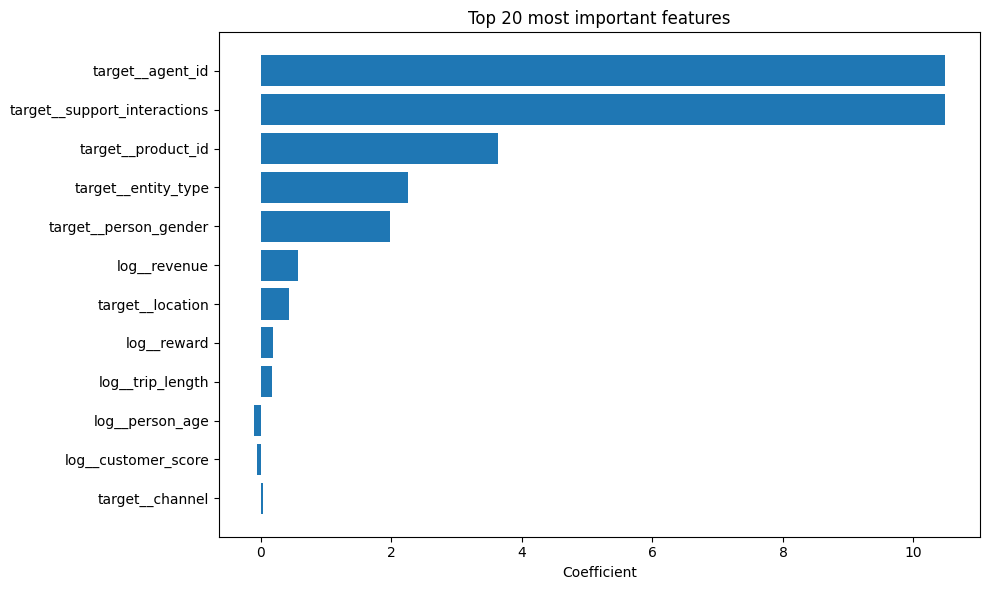

In [35]:
# Model
log_reg_model = best_log.named_steps['classifier']

# Feature names after preprocessing
feature_names = best_log.named_steps['preprocessing'].get_feature_names_out()

# Fix names for target encoding
target_cols = ['entity_type','person_gender', 'agent_id','product_id', 'location', 'channel', 'support_interactions', 'entity_a']
for i, col in enumerate(target_cols):
    feature_names = [name.replace(f'target__{i}', f'target__{col}') for name in feature_names]

# Model coefficients
coefficients = log_reg_model.coef_[0]

# DataFrame with results
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'AbsCoefficient': abs(coefficients)
}).sort_values(by='AbsCoefficient', ascending=False)

# Plot with readable names
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:20][::-1], coef_df['Coefficient'][:20][::-1])
plt.xlabel("Coefficient")
plt.title("Top 20 most important features")
plt.tight_layout()
plt.show()

#### SVM

I've been testing SVM algorythm with different modes, but I had to split it into few parts, due to the memory issues. I've tested 3 kernels: linear, rbf and poly. All of them I've tested with different C Values. The best results were achieved with linear kerner, however they were worse than the results of logistic regression, so I decided to not use SVM in the final model.

In [ ]:
# # ==== CONFIGURATION ====
# # Model parameters - adjust based on computational capacity
# kernels = ['linear']  # SVM kernels to test
# C_values = [0.1 0.2, 0.5]  # Regularization strength values

# # ==== ITERATE THROUGH OPTIONS ====
# print("\nTraining on FULL dataset (no subsampling)")
    
# # Use complete training data (no subsampling)
# X_full, y_full = X_train, y_train

# for kernel in kernels:
#     print(f"Kernel: {kernel}")
    
#     # Create SVM model with specified kernel
#     svm_model = SVC(
#         kernel=kernel, 
#         class_weight='balanced',  # Handle class imbalance
#         probability=True  # Enable probability estimates
#     )

#     # Adjust parameter grid based on kernel
#     if kernel == 'linear':
#         param_grid = {'svc__C': C_values}

#     # Create pipeline with preprocessing
#     # StandardScaler helps SVM performance even with preprocessed features
#     model_with_scaler = make_pipeline(
#         StandardScaler(), 
#         svm_model
#     )

#     # Model identifier
#     model_name = f"SVM ({kernel}, full dataset)"

#     # Train and tune model
#     best_model = train_and_tune_model(
#         model_with_scaler, 
#         param_grid, 
#         X_full, 
#         y_full, 
#         X_val, 
#         y_val, 
#         model_name=model_name
#     )

In [ ]:
# # ==== CONFIGURATION ====
# # Model parameters - adjust based on computational capacity
# kernels = ['rbf']  # SVM kernels to test
# C_values = [0.2]  # Regularization strength values

# # ==== ITERATE THROUGH OPTIONS ====
# print("\nTraining on FULL dataset (no subsampling)")
    
# # Use complete training data (no subsampling)
# X_full, y_full = X_train, y_train

# for kernel in kernels:
#     print(f"Kernel: {kernel}")
    
#     # Create SVM model with specified kernel
#     svm_model = SVC(
#         kernel=kernel, 
#         class_weight='balanced',  # Handle class imbalance
#         probability=True  # Enable probability estimates
#     )

#     # Adjust parameter grid based on kernel
#     if kernel == 'linear':
#         param_grid = {'svc__C': C_values}

#     # Create pipeline with preprocessing
#     # StandardScaler helps SVM performance even with preprocessed features
#     model_with_scaler = make_pipeline(
#         StandardScaler(), 
#         svm_model
#     )

#     # Model identifier
#     model_name = f"SVM ({kernel}, full dataset)"

#     # Train and tune model
#     best_model = train_and_tune_model(
#         model_with_scaler, 
#         param_grid, 
#         X_full, 
#         y_full, 
#         X_val, 
#         y_val, 
#         model_name=model_name
#     )

In [38]:
# # Now lets do classic svm but do sampling to make it faster
# from sklearn.svm import SVC
# from sklearn.utils import resample

# # Step 1: Subsample the training data
# # You can tweak `n_samples` depending on your machine's performance
# n_samples = 30000

# X_sub, y_sub = resample(X_train, y_train, 
#                         replace=False, 
#                         n_samples=n_samples, 
#                         stratify=y_train, 
#                         random_state=42)

# # Step 2: Define SVM model (with linear or RBF kernel for starters)
# svm_model = SVC(kernel='poly', class_weight='balanced')  # or 'linear', 'poly'

# # Step 3: Define a simple parameter grid
# svm_param_grid = {
#     'C': [100],
#     'gamma': ['scale']
# }

# # Step 4: Tune on the subsampled data
# best_svm = train_and_tune_model(svm_model, svm_param_grid, X_sub, y_sub, X_val, y_val, model_name='Classic SVM (subsampled)')


In [39]:
# # Now lets do classic svm but do sampling to make it faster
# from sklearn.svm import SVC
# from sklearn.utils import resample

# # Step 1: Subsample the training data
# # You can tweak `n_samples` depending on your machine's performance
# n_samples = 30000

# X_sub, y_sub = resample(X_train, y_train, 
#                         replace=False, 
#                         n_samples=n_samples, 
#                         stratify=y_train, 
#                         random_state=42)

# # Step 2: Define SVM model (with linear or RBF kernel for starters)
# svm_model = SVC(kernel='poly', class_weight='balanced')  # or 'linear', 'poly'

# # Step 3: Define a simple parameter grid
# svm_param_grid = {
#     'C': [10],
#     'gamma': ['scale']
# }

# # Step 4: Tune on the subsampled data
# best_svm = train_and_tune_model(svm_model, svm_param_grid, X_sub, y_sub, X_val, y_val, model_name='Classic SVM (subsampled)')

In [40]:
# # Now lets do classic svm but do sampling to make it faster
# from sklearn.svm import SVC
# from sklearn.utils import resample

# # Step 1: Subsample the training data
# # You can tweak `n_samples` depending on your machine's performance
# n_samples = 30000

# X_sub, y_sub = resample(X_train, y_train, 
#                         replace=False, 
#                         n_samples=n_samples, 
#                         stratify=y_train, 
#                         random_state=42)

# # Step 2: Define SVM model (with linear or RBF kernel for starters)
# svm_model = SVC(kernel='poly', class_weight='balanced')  # or 'linear', 'poly'

# # Step 3: Define a simple parameter grid
# svm_param_grid = {
#     'C': [1],
#     'gamma': ['scale']
# }

# # Step 4: Tune on the subsampled data
# best_svm = train_and_tune_model(svm_model, svm_param_grid, X_sub, y_sub, X_val, y_val, model_name='Classic SVM (subsampled)')

#### KNN

In [56]:
# KNN
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [15,17,19],
    'weights': ['uniform'],
    'metric': ['minkowski'],
    'p': [1],  # for Minkowski: p=1 (Manhattan), p=2 (Euclidean)
    'algorithm': ['auto']
}

best_knn = train_and_tune_model(
    knn_model,
    knn_param_grid,
    X_train,
    y_train,
    X_val,
    y_val,
    model_name='KNN'
)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
KNN Results
Best parameters: {'classifier__algorithm': 'auto', 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 19, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Validation balanced accuracy: 0.6928


#### Final Model Training

Fitting 3 folds for each of 4 candidates, totalling 12 fits
🔍 Final Model Results
Best parameters: {'classifier__C': 0.1}
Validation balanced accuracy: 0.8036
📊 FINAL RESULTS ON TEST SET
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      8424
           1       0.05      0.64      0.09       125

    accuracy                           0.81      8549
   macro avg       0.52      0.73      0.49      8549
weighted avg       0.98      0.81      0.88      8549

AUC-ROC: 0.7941


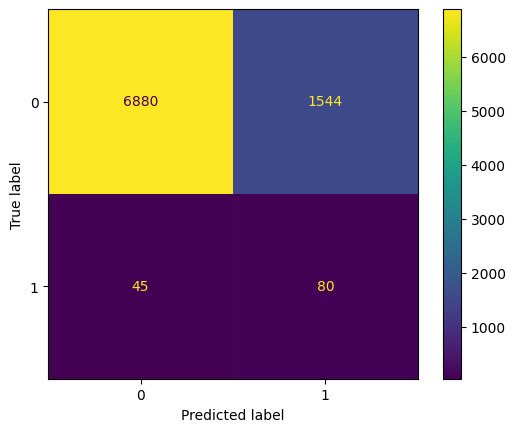

In [ ]:
# Train the best model on full training data (train + val)
best_model = train_and_tune_model(
    log_model, log_param_grid, 
    pd.concat([X_train, X_val]),  # Combine train and val
    pd.concat([y_train, y_val]), 
    X_val,
    y_val,
    model_name="Final Model"
)

# Evaluation on test set (which was NEVER used before)
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]  # For metrics like AUC-ROC

# Generate report
from sklearn.metrics import classification_report, roc_auc_score

print("FINAL RESULTS ON TEST SET")
print(classification_report(y_test, y_test_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")


# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.show()

## PREDICTIONS

#### Predictions for all observations in test dataset

In [ ]:
# Load test data
df_test = pd.read_csv(f"{raw_input_data_path}/insurance_test.csv")

# Preserve identifier (if exists, e.g., claim_id or other unique ID)
# If no identifier exists, keep the index as reference
df_test_reset = df_test.reset_index(drop=True)

# Apply data transformations - same preprocessing as training set 
# (preprocessor was already fitted during training)
X_test = df_test[log_cols + target_cols].copy()

# Generate probabilistic predictions and class predictions
claim_proba = best_log.predict_proba(X_test)[:, 1]  # Probability of positive class
claim_pred = best_log.predict(X_test)  # Binary class predictions

# Combine predictions with original test data
df_test_with_preds = df_test_reset.copy()
df_test_with_preds['claim_proba'] = claim_proba  # Add probability predictions
df_test_with_preds['claim_pred'] = claim_pred    # Add class predictions

# Export results and preview
df_test_with_preds.to_csv(f"{preprocessed_output_data_path}/insurance_test_with_predictions.csv", index=False)
print("Test data with predictions preview:")
df_test_with_preds.head()